# Bandung House Price Analysis

## Introduction

Bandung, sebagai salah satu kota besar di Indonesia, terus mengalami pertumbuhan pesat dalam sektor properti, khususnya pasar perumahan. Dalam project ini, akan fokus pada data harga rumah di Bandung yang telah dikumpulkan dari situs properti rumah123.com. Seiring dengan bertambahnya data properti yang tersedia secara online, pengolahan dan analisis data menjadi semakin penting untuk mendukung pengambilan keputusan, baik oleh pembeli, penjual, maupun investor.

Dalam analisis ini, kita akan menerapkan prinsip ETL (Extract, Transform, Load) untuk memastikan data yang digunakan bersih, konsisten, dan terstruktur. Proses ini akan dilanjutkan dengan eksplorasi data (EDA) untuk menggali insight mengenai pola harga rumah berdasarkan lokasi, luas bangunan, luas tanah, dan atribut lainnya. Tujuan utama dari project ini adalah memberikan gambaran mengenai tren harga rumah di Bandung untuk mendukung pengambilan keputusan yang lebih baik.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

import folium
from folium.plugins import HeatMap
from geopy.geocoders import Nominatim


import re

import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', 50)
pd.set_option('display.max_rows', 500)
pd. set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('bandung_house_price.csv')
df.head()

,id_listing,judul,harga,alamat,kamar_tidur,kamar_mandi,garasi/carport,luas_tanah,luas_bangunan
0,hos13355611,Rumah Classic Bergaya Victorian Setraduta Full...,"Rp 2,65 Miliar","Setra Duta, Bandung",3.0,3.0,2.0,: 76 m²,: 225 m²
1,hos13440338,Dijual Rumah Kopo Ketapang,Rp 925 Juta,"Kopo, Bandung",2.0,1.0,2.0,: 168 m²,: 45 m²
2,hos16919960,Dijual Rumah Setra Duta Bergaya Modern Dengan ...,"Rp 8,2 Miliar","Setra Duta, Bandung",4.0,3.0,3.0,: 389 m²,: 400 m²
3,hos16920034,Rumah Setraduta Modern Bangunan Baru Dilengkap...,"Rp 3,75 Miliar","Setra Duta, Bandung",4.0,3.0,2.0,: 138 m²,: 210 m²
4,hos8859825,"Rumah Classic Pajajaran, 4 Menit Ke Bandara Hu...",Rp 12 Miliar,"Bandung Kota, Bandung",8.0,2.0,2.0,: 359 m²,: 150 m²


### Feature Explanation
- `id_listings`: Merupakan ID unik untuk setiap listing properti yang diiklankan, digunakan untuk membedakan satu listing dengan yang lain.
- `judul`: Judul atau nama listing yang ditentukan oleh pengiklan sebagai deskripsi singkat dari properti rumah yang dijual.
- `harga`: Harga yang ditawarkan untuk properti rumah yang diiklankan, dinyatakan dalam mata uang lokal.
- `alamat`: Lokasi properti yang mencantumkan nama kecamatan dan diikuti dengan nama kota tempat rumah tersebut berada.
- `kamar_tidur`: Jumlah kamar tidur yang tersedia pada rumah yang dijual.
- `kamar_mandi`: Jumlah kamar mandi yang tersedia pada rumah yang dijual.
- `garasi/carport`: Kapasitas ruang parkir, menunjukkan jumlah mobil yang dapat ditampung dalam garasi atau carport.
- `luas_tanah`: Total luas tanah properti yang diukur dalam satuan meter persegi (m²).
- `luas_bangunan`: Total luas bangunan pada properti yang diukur dalam satuan meter persegi (m²).

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4185 entries, 0 to 4184
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id_listing      4185 non-null   object 
 1   judul           4185 non-null   object 
 2   harga           4185 non-null   object 
 3   alamat          4185 non-null   object 
 4   kamar_tidur     4179 non-null   float64
 5   kamar_mandi     4176 non-null   float64
 6   garasi/carport  3262 non-null   float64
 7   luas_tanah      4185 non-null   object 
 8   luas_bangunan   4185 non-null   object 
dtypes: float64(3), object(6)
memory usage: 294.4+ KB


In [4]:
df.describe()

,kamar_tidur,kamar_mandi,garasi/carport
count,4179.000000,4176.000000,3262.000000
mean,3.797799,2.801485,1.765481
std,2.580543,2.406102,1.403504
min,1.000000,1.000000,1.000000
25%,3.000000,2.000000,1.000000
50%,3.000000,3.000000,1.000000
75%,4.000000,3.000000,2.000000
max,100.000000,100.000000,30.000000


In [5]:
df.isna().sum()

id_listing          0
judul               0
harga               0
alamat              0
kamar_tidur         6
kamar_mandi         9
garasi/carport    923
luas_tanah          0
luas_bangunan       0
dtype: int64

# Data Cleansing
#### Overview

1. Extract value `harga` kedalam satuan numeric 
2. Merubah tipe data `kamar_tidur`, `kamar_mandi`, `garasi/carport` menjadi integer
3. Extract value `luas_tanah`, `luas_bangunan` menjadi angka numeric dengan satuan square meter (sqm)
4. Mendapatkan nilai kecamatan dari field field alamat
5. Handling missing values
6. Check & Handling Outlier

### Duplicate Check

In [6]:
df.duplicated().sum()

0

In [7]:
df.drop_duplicates(subset='id_listing', inplace=True)
df.duplicated().sum()

0

> Drop data duplicate berdasarkan id_listing

### `Harga`

In [8]:
df['harga'].sample(20)

352     Rp 2,45 Miliar
2337     Rp 1,4 Miliar
4043    Rp 3,35 Miliar
2302    Rp 1,61 Miliar
3440       Rp 900 Juta
2221    Rp 1,65 Miliar
4133     Rp 1,5 Miliar
1258     Rp 2,5 Miliar
1670     Rp 1,1 Miliar
3558       Rp 820 Juta
452     Rp 1,39 Miliar
528       Rp 12 Miliar
1022    Rp 2,92 Miliar
101      Rp 1,1 Miliar
351      Rp 5,5 Miliar
3653       Rp 5 Miliar
1477     Rp 2,6 Miliar
786      Rp 2,5 Miliar
3612    Rp 1,15 Miliar
2517       Rp 6 Miliar
Name: harga, dtype: object

In [9]:
def convert_harga(harga):
    
    # Remove 'Rp' and whitespace
    harga_clean = harga.replace('Rp', '').replace(',', '.').strip()
    
    # Check units "miliar" or "Juta"
    if 'Miliar' in harga_clean:
        multiplier = 1000000000
        harga_clean = harga_clean.replace('Miliar', '').strip()
    elif 'Juta' in harga_clean:
        multiplier = 1000000
        harga_clean = harga_clean.replace('Juta', '').strip()
    else:
        multiplier = 1
    
    try:
        return int(float(harga_clean) * multiplier)
    except ValueError:
        return None

In [10]:
df['harga_rp'] = df['harga'].apply(convert_harga)
df[['harga_rp']].describe()

,harga_rp
count,4.185000e+03
mean,3.567232e+09
std,5.373507e+09
min,1.100000e+08
25%,1.250000e+09
50%,2.250000e+09
75%,3.900000e+09
max,1.500000e+11


### `kamar_tidur`,  `kamar_mandi`

In [11]:
df[['kamar_tidur', 'kamar_mandi']].isna().sum()

kamar_tidur    6
kamar_mandi    9
dtype: int64

In [12]:
df.dropna(subset=['kamar_tidur','kamar_mandi'], inplace=True)
df[['kamar_tidur', 'kamar_mandi']] = df[['kamar_tidur', 'kamar_mandi']].astype('int64')
df[['kamar_tidur', 'kamar_mandi']].isna().sum()

kamar_tidur    0
kamar_mandi    0
dtype: int64

Berdasarkan hasil pengecekan data, ditemukan beberapa field kamar_tidur dan kamar_mandi memiliki nilai NaN. Hal ini kemungkinan disebabkan oleh kesalahan input pada website (human error) atau error selama proses scraping. Mengingat tidak logis jika sebuah rumah tidak memiliki kamar tidur dan kamar mandi, baris data dengan nilai NaN pada kedua field tersebut diputuskan untuk dihapus dari dataset.

### `garasi/carport`

In [13]:
df['garasi/carport'].describe()

count    3262.000000
mean        1.765481
std         1.403504
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        30.000000
Name: garasi/carport, dtype: float64

In [14]:
pd.set_option('display.float_format', '{:.0f}'.format)

df[df['garasi/carport'].isna()].describe()[['garasi/carport', 'harga_rp']]

,garasi/carport,harga_rp
count,0,914
mean,NaN,3178318381
std,NaN,5678099042
min,NaN,150000000
25%,NaN,1200000000
50%,NaN,1950000000
75%,NaN,3367500000
max,NaN,139000000000


In [15]:
df[(df['harga_rp'] <= 150000000) & (df['garasi/carport'].isna())]

,id_listing,judul,harga,alamat,kamar_tidur,kamar_mandi,garasi/carport,luas_tanah,luas_bangunan,harga_rp
120,hos18856121,Bintang Lovina Pperumahan Dengan Konsep Scandi...,Rp 150 Juta,"Kopo, Bandung",2,1,NaN,: 50 m²,: 30 m²,150000000


In [16]:
df[(df['harga_rp'] <= 150000000) & (df['garasi/carport'].isna())].fillna(0, inplace=True)
df['garasi/carport'].fillna(df['garasi/carport'].median() , inplace=True)

df['garasi/carport'] = df['garasi/carport'].astype('int64')
df['garasi/carport'].isna().sum()

0

Untuk field garasi/carport yang memiliki nilai NaN, penanganannya dilakukan dengan pendekatan berikut:

1. Untuk rumah dengan harga di bawah 150 juta dan luas tanah tidak lebih dari 50 meter persegi, nilai garasi/carport diisi dengan 0. Hal ini didasarkan pada asumsi bahwa rumah dengan harga dan luas tanah tersebut biasanya berada di dalam gang sempit yang tidak memiliki garasi atau carport.
2. Untuk data lainnya dengan harga diatas 150 juta yang memiliki nilai NaN, nilai garasi/carport diisi dengan nilai mediannya yaitu 1.
Pendekatan ini dilakukan untuk menjaga konsistensi dan akurasi data berdasarkan karakteristik umum rumah sesuai kategori harga dan luas tanah.anah.

### `luas_tanah`, `luas_bangunan`

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4176 entries, 0 to 4184
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id_listing      4176 non-null   object
 1   judul           4176 non-null   object
 2   harga           4176 non-null   object
 3   alamat          4176 non-null   object
 4   kamar_tidur     4176 non-null   int64 
 5   kamar_mandi     4176 non-null   int64 
 6   garasi/carport  4176 non-null   int64 
 7   luas_tanah      4176 non-null   object
 8   luas_bangunan   4176 non-null   object
 9   harga_rp        4176 non-null   int64 
dtypes: int64(4), object(6)
memory usage: 358.9+ KB


In [18]:
df[['luas_tanah','luas_bangunan']].sample(5)

,luas_tanah,luas_bangunan
3401,: 135 m²,: 164 m²
3451,: 162 m²,: 250 m²
903,: 203 m²,: 211 m²
2013,: 250 m²,: 325 m²
4138,: 90 m²,: 130 m²


In [19]:
df[['luas_tanah', 'luas_bangunan']].isna().sum()

luas_tanah       0
luas_bangunan    0
dtype: int64

In [20]:
df.dropna(subset=['luas_bangunan'], inplace=True)

In [21]:
#convert to numeric
df['luas_tanah_sqm'] = df['luas_tanah'].apply(lambda x: str(x).replace(':','').replace('m²','').strip()).astype('int64')
df['luas_bangunan_sqm'] = df['luas_bangunan'].apply(lambda x: str(x).replace(':','').replace('m²','').strip()).astype('int64')

In [22]:
df[['luas_tanah_sqm', 'luas_bangunan_sqm']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4176 entries, 0 to 4184
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   luas_tanah_sqm     4176 non-null   int64
 1   luas_bangunan_sqm  4176 non-null   int64
dtypes: int64(2)
memory usage: 97.9 KB


Field luas_tanah dan luas_bangunan dikonversi menjadi format numerik untuk mempermudah proses analisis data. Sementara itu, baris data dengan nilai luas_bangunan yang null diputuskan untuk dihapus (drop) dari dataset guna menjaga kualitas dan konsistensi data yang digunakan.

### `alamat`

In [23]:
df['daerah'] = df['alamat'].str.split(',').str[0].str.strip()
df['kota'] = df['alamat'].str.split(',').str[1].str.strip()

In [24]:
df['daerah'].unique()

array(['Setra Duta', 'Kopo', 'Bandung Kota', 'Pasteur', 'Buah Batu',
       'Holis Cigondewah', 'Gede Bage', 'Lengkong', 'Cicendo',
       'Batununggal', 'Cibiru', 'Singgasana', 'Soekarno Hatta',
       'Turangga', 'Tubagus Ismail', 'Antapani', 'Dago', 'Arcamanik',
       'Summarecon Bandung', 'Padasuka', 'Sayap Dago', 'Caringin',
       'Rancasari', 'Geger Kalong', 'Cipaganti', 'Cijerah', 'Pajajaran',
       'Bandung Timur', 'Bandung Utara', 'Setiabudi', 'Ciwastra',
       'Terusan Buah Batu', 'Cikutra', 'Ujungberung', 'Sukaluyu',
       'Dago Pakar', 'Setra Sari', 'Surya Sumantri', 'Sudirman',
       'Cigadung', 'Ciumbuleuit', 'BKR', 'Regol', 'Gatot Subroto',
       'Mekar Wangi', 'Gunung Batu', 'Moch Toha', 'Hegarmanah',
       'Kopo Permai', 'Kiaracondong', 'Riau', 'Sukajadi', 'Astanaanyar',
       'Cijagra', 'Sukahaji', 'Andir', 'Cicaheum', 'Burangrang', 'Garuda',
       'Cilengkrang', 'Pasir Koja', 'Pungkur', 'Cipaku', 'Awiligar',
       'Cibaduyut', 'Bojongloa', 'Pasir Luyu', 'M

In [25]:
#load data tambahan (source:https://id.wikipedia.org/wiki/Daftar_kecamatan_dan_kelurahan_di_Kota_Bandung)
df_kelurahan = pd.read_csv('kelurahan_bandung.csv')
df_kelurahan.sample(5)

,kelurahan,kecamatan
92,Pasirbiru,Cibiru
62,Kopo,Bojongloa Kaler
26,Babakanciparay,Babakan Ciparay
53,Kacapiring,Batununggal
77,Cigadung,Cibeunying Kaler


In [26]:
#Extract kecamatan berdasarkan field daerah
mapping_dict = pd.Series(df_kelurahan.kecamatan.values, index=df_kelurahan.kelurahan.str.lower()).to_dict()
df['kecamatan'] = df['daerah'].str.lower().apply(lambda x: mapping_dict.get(x, None))
df['kecamatan'].unique()

array([None, 'Bojongloa Kaler', 'Sukajadi', 'Lengkong', 'Cicendo',
       'Batununggal', 'Cibiru', 'Antapani', 'Coblong', 'Arcamanik',
       'Cibeunying Kidul', 'Bandung Kulon', 'Rancasari', 'Ujungberung',
       'Cibeunying Kaler', 'Cidadap', 'Regol', 'Kiaracondong',
       'Astana Anyar', 'Babakan Ciparay', 'Andir', 'Bojongloa Kidul',
       'Sukasari', 'Bandung Kidul', 'Bandung Wetan', 'Mandalajati',
       'Sumur Bandung', 'Panyileukan'], dtype=object)

In [27]:
print(df[df['kecamatan'].isnull()]['daerah'].nunique())

64


Ternyata alamat tidak selalu <b>(kecamatan, kota)</b>, akhirnya terdapat 114 daerah tidak berhasil di dapatkan nama kecamatannya

In [28]:
#mapping manual kecamatan berdasarkan daerah untuk beberapa daerah yang tidak berhasil convert dari data df_kelurahan
kecamatan_dict = {
    "setra duta": "Sukasari",
    "bandung kota": "Sumur Bandung",
    "buah batu": "Buah Batu",
    "holis cigondewah": "Astana Anyar",
    "gede bage": "Gedebage",
    "setiabudi": "Sukasari",
    "soekarno hatta": "Kiaracondong",
    "tubagus ismail": "Coblong",
    "riau": "Cibeunying Kaler",
    "summarecon bandung": "Gedebage",
    "sayap dago": "Coblong",
    "moch toha": "Regol",
    "geger kalong": "Sukasari",
    "kopo permai": "Bojongloa Kaler",
    "bandung timur": "Arcamanik",
    "bandung utara": "Cidadap",
    "ciwastra": "Buah Batu",
    "terusan buah batu": "Lengkong",
    "dago pakar": "Coblong",
    "resor dago pakar": "Coblong",
    "setra sari": "Sukasari",
    "surya sumantri": "Sukasari",
    "cihampelas": "Coblong",
    "mekar wangi": "Bojongloa Kidul",
    "awiligar": "Cibeunying Kaler",
    "bkr": "Lengkong",
    "gunung batu": "Sukasari",
    "supratman": "Cibeunying Kidul",
    "cibeunying": "Cibeunying Kaler",
    "margacinta": "Buah Batu",
    "pasir kaliki": "Cicendo",
    "cipaku": "Cidadap",
    "pasir koja": "Bojongloa Kaler",
    "leuwi panjang": "Bojongloa Kidul",
    "setra indah": "Sukasari",
    "sudirman": "Astana Anyar",
    "peta": "Bojongloa Kaler",
    "asia afrika": "Sumur Bandung",
    "gatot subroto": "Lengkong",
    "pelajar pejuang": "Lengkong",
    "surapati": "Cibeunying Kaler",
    "cibeureum": "Cicendo",
    "pasir luyu": "Regol",
    "wastukencana": "Bandung Wetan",
    "suci": "Cibeunying Kidul",
    "bojongloa": "Bojongloa Kidul",
    "kebon kawung": "Cicendo",
    "veteran": "Sumur Bandung",
    "laswi": "Lengkong",
    "talaga bodas": "Lengkong",
    "Margahayu": "Babakan Ciparay",
    "cilengkrang": "Cibiru",
    "singgasana": "Bojongloa Kidul"
}


In [29]:
df['kecamatan'] = df.apply(
    lambda row: kecamatan_dict.get(row['daerah'].lower(), row['kecamatan']) if pd.isna(row['kecamatan']) else row['kecamatan'],
    axis=1
)

In [30]:
print('unique list daerah with Null kecamatan:\n', df[df['kecamatan'].isna()]['daerah'].unique(),'\n')
print('total rows Null kecamatan:', df['kecamatan'].isna().sum())

unique list daerah with Null kecamatan:
 ['Dekat Akses Transportasi' 'Full Furnished' 'Siap Huni' 'Dekat Sekolah'
 'Dekat Pusat Perbelanjaan' 'Bebas Banjir' 'Subsidi' 'Dekat Tempat Ibadah'
 'Dekat Fasilitas Kesehatan' 'Baru dibangun' 'Baru direnovasi'
 'Over Kredit' 'Dekat Landmark' 'DP 0%' 'Dekat Tempat Wisata'] 

total rows Null kecamatan: 1874


In [31]:
df = df.dropna(subset='kecamatan')
df['kecamatan'].isna().sum()

0

terdapat 4634 baris data yang tidak mendapatkan kecamatan karena termasuk kedalam daerah kabupaten bandung. Namun ada juga beberapa data yang tidak dapat di identifikasi seperti Dekat Tempat Ibadah, Dekat Tempat Wisata, dll.

In [32]:
print(sorted(df['kecamatan'].unique()))
print('\nTotal kecamatan: ',df['kecamatan'].nunique())

['Andir', 'Antapani', 'Arcamanik', 'Astana Anyar', 'Babakan Ciparay', 'Bandung Kidul', 'Bandung Kulon', 'Bandung Wetan', 'Batununggal', 'Bojongloa Kaler', 'Bojongloa Kidul', 'Buah Batu', 'Cibeunying Kaler', 'Cibeunying Kidul', 'Cibiru', 'Cicendo', 'Cidadap', 'Coblong', 'Gedebage', 'Kiaracondong', 'Lengkong', 'Mandalajati', 'Panyileukan', 'Rancasari', 'Regol', 'Sukajadi', 'Sukasari', 'Sumur Bandung', 'Ujungberung']

Total kecamatan:  29


In [33]:
#Drop beberapa kolom yang tidak di perlukan, lalu salin kedalam variable df_clean
df_clean = df.drop(columns=['luas_tanah','luas_bangunan','daerah','kota'])

1. Field alamat tidak selalu mengikuti format nama kecamatan/kelurahan yang diikuti oleh nama kota. Banyak data yang justru diawali dengan nama jalan. Untuk mengatasi hal ini, dilakukan mapping manual dengan bantuan Google Maps untuk menentukan kecamatan yang sesuai.
2. Karena analisis data difokuskan pada harga rumah di Kota Bandung, maka data pada field alamat/kecamatan yang berada di wilayah Kabupaten Bandung diputuskan untuk dihapus dari dataset.

# EDA (Exploratory Data Analysis)
1. Outlier check
2. Distribusi harga rumah
3. Segmentasi Rumah berdasarkan Harga
4. Faktor apa yang mempengaruhi harga rumah

### Outlier

In [34]:
df_clean.describe()

,kamar_tidur,kamar_mandi,garasi/carport,harga_rp,luas_tanah_sqm,luas_bangunan_sqm
count,2302,2302,2302,2302,2302,2302
mean,4,3,2,3524215899,241,220
std,1,1,1,3695202448,223,236
min,1,1,1,125000000,30,28
25%,3,2,1,1250000000,108,103
50%,3,3,1,2300000000,167,170
75%,4,3,2,4099999999,300,290
max,11,11,12,20000000000,2448,8000


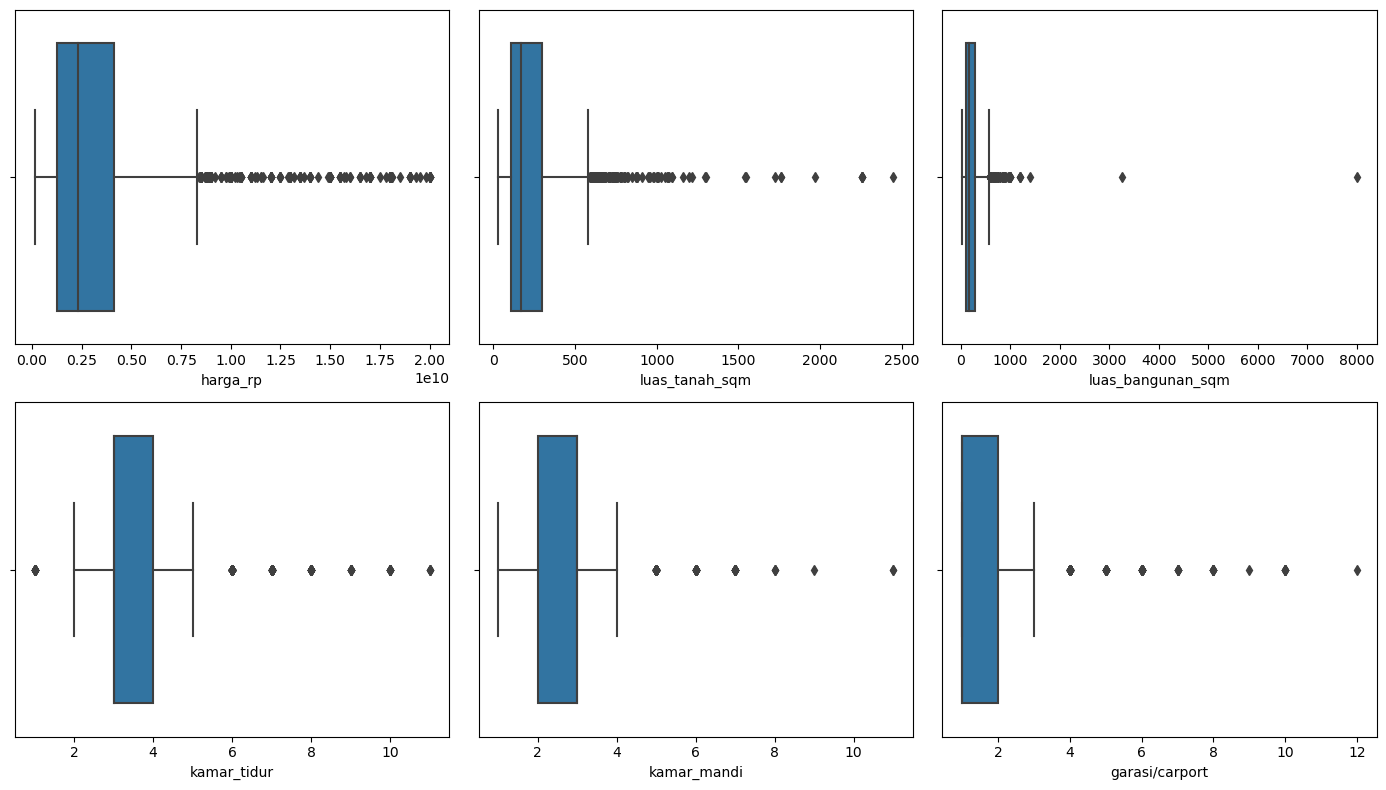

In [35]:
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
columns = ['harga_rp','luas_tanah_sqm','luas_bangunan_sqm','kamar_tidur','kamar_mandi','garasi/carport']
for i, col in enumerate(columns):
    row = i // 3 
    col_idx = i % 3 
    sns.boxplot(df_clean[col], ax=axes[row, col_idx])

plt.tight_layout()
plt.show()

In [36]:
def find_outlier (df, list_columns):
    list_outliers = []
    for col in list_columns:
        
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3-Q1

        lower_bound = Q1 - 1.5*IQR
        upper_bound = Q3 + 1.5*IQR

        outliers = {
            'column':col,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound
            }
        list_outliers.append(outliers)
        
    df_outliers = pd.DataFrame(list_outliers)
    return df_outliers

In [37]:
find_outlier(df_clean, columns)

,column,lower_bound,upper_bound
0,harga_rp,-3024999998,8374999998
1,luas_tanah_sqm,-180,588
2,luas_bangunan_sqm,-177,570
3,kamar_tidur,2,6
4,kamar_mandi,0,4
5,garasi/carport,-0,4


In [38]:
#stats deskriptif rumah dengan harga diatas upper bound
df_clean[df_clean['harga_rp'] > 9_050_000_000 ].describe()

,kamar_tidur,kamar_mandi,garasi/carport,harga_rp,luas_tanah_sqm,luas_bangunan_sqm
count,163,163,163,163,163,163
mean,5,4,4,14374233129,713,488
std,2,2,2,3223282181,421,233
min,1,1,1,9200000000,282,125
25%,4,3,2,11500000000,470,313
50%,5,4,3,14000000000,600,450
75%,6,4,4,17000000000,766,600
max,11,11,12,20000000000,2448,1400


In [39]:
df_clean[df_clean['harga_rp'] > 9_050_000_000 ]['kecamatan'].unique()

array(['Sumur Bandung', 'Sukasari', 'Coblong', 'Batununggal', 'Sukajadi',
       'Cidadap', 'Cibeunying Kaler', 'Cicendo', 'Lengkong', 'Gedebage',
       'Buah Batu', 'Bandung Wetan', 'Bojongloa Kidul', 'Astana Anyar',
       'Andir', 'Kiaracondong', 'Cibeunying Kidul'], dtype=object)

Rumah yang memiliki harga di atas upper bound (batas atas) jika dilihat dari rata2 dan median luas tanah, luas bangunan, jml kamar tidur dan juga kecamatan rumah tersebut berada, data tersebut cukup valid.

In [40]:
df_clean.describe()

,kamar_tidur,kamar_mandi,garasi/carport,harga_rp,luas_tanah_sqm,luas_bangunan_sqm
count,2302,2302,2302,2302,2302,2302
mean,4,3,2,3524215899,241,220
std,1,1,1,3695202448,223,236
min,1,1,1,125000000,30,28
25%,3,2,1,1250000000,108,103
50%,3,3,1,2300000000,167,170
75%,4,3,2,4099999999,300,290
max,11,11,12,20000000000,2448,8000


In [41]:
df_clean[df_clean['kamar_tidur'] >= 10]

,id_listing,judul,harga,alamat,kamar_tidur,kamar_mandi,garasi/carport,harga_rp,luas_tanah_sqm,luas_bangunan_sqm,kecamatan
142,hos18151792,"Dijual Rumah Lokasi Premium Di Cisitu Indah, D...",Rp 10 Miliar,"Dago, Bandung",10,4,2,10000000000,668,360,Coblong
296,hos18854580,Rumah Bagus 2 Lantai Siap Huni Di Pondok Hijau...,"Rp 2,75 Miliar","Setiabudi, Bandung",10,7,2,2750000000,462,410,Sukasari
764,hos18223079,Dijual Rumah Sayap Laswi Dekat Tsm,Rp 10 Miliar,"Laswi, Bandung",10,4,4,10000000000,443,545,Lengkong
895,hos10944730,RUMAH TINGGAL DI SAYAP BUAH BATU,"Rp 4,9 Miliar","Buah Batu, Bandung",10,7,1,4900000000,387,600,Buah Batu
909,hos16994820,Rumah Elite Hegarmanah,"Rp 9,9 Miliar","Cidadap, Bandung",10,6,1,9900000000,612,420,Cidadap
1035,hos17713515,"Rumah luas murah di pasirluyu, BKR - Lingkar s...","Rp 6,2 Miliar","BKR, Bandung",10,5,2,6200000000,542,500,Lengkong
1236,hos14878572,"Rumah Cantik 3,5 Lantai Setraduta Hegar Bagus ...","Rp 5,6 Miliar","Setra Duta, Bandung",10,7,1,5600000000,250,800,Sukasari
1291,hos16757295,DIJUAL RUMAH STRATEGIS UTK USAHA CAFE & RESTO ...,Rp 8 Miliar,"Riau, Bandung",10,7,4,8000000000,390,265,Cibeunying Kaler
1715,hos19034514,Rumah Sayap Gatot Subroto Nyaman,Rp 14 Miliar,"Lengkong, Bandung",10,5,2,14000000000,476,300,Lengkong
1984,hos18294798,Rumah Besar Strategis Cocok Usaha di Setra Sari,Rp 6 Miliar,"Setra Sari, Bandung",11,11,1,6000000000,200,350,Sukasari


In [42]:
# takeout bangunan komersial
df_clean = df_clean[~df_clean['judul'].str.contains('hotel|motel|kost|kos|kosan|Guest house|Pom Bensin|gedung|kantor|guesthouse|villa', case=False)]
df_clean.describe()

,kamar_tidur,kamar_mandi,garasi/carport,harga_rp,luas_tanah_sqm,luas_bangunan_sqm
count,2302,2302,2302,2302,2302,2302
mean,4,3,2,3524215899,241,220
std,1,1,1,3695202448,223,236
min,1,1,1,125000000,30,28
25%,3,2,1,1250000000,108,103
50%,3,3,1,2300000000,167,170
75%,4,3,2,4099999999,300,290
max,11,11,12,20000000000,2448,8000


jumlah kamar tidur dan kamar mandi yang sangat banyak bahkan mencapai angka 40 ternyata adalah bangunan komersial seperti hotel, indekos dll. Bangunan komersil di takeout agar analisis tetap relevan dengan rumah tinggal (residensial)

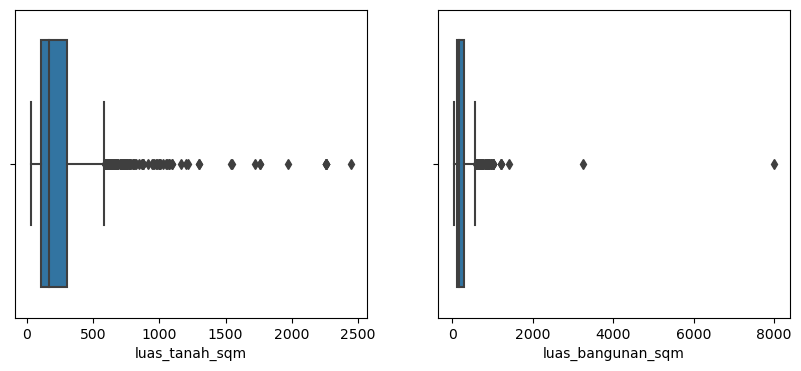

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.boxplot(df_clean['luas_tanah_sqm'], ax=axes[0])
sns.boxplot(df_clean['luas_bangunan_sqm'], ax=axes[1])

plt.show()

In [44]:
df_clean[df_clean['luas_tanah_sqm'] >=2000]

,id_listing,judul,harga,alamat,kamar_tidur,kamar_mandi,garasi/carport,harga_rp,luas_tanah_sqm,luas_bangunan_sqm,kecamatan
225,hos18957441,"Rumah Lux Bagus di Dago Pakar Resort, Bandung",Rp 19 Miliar,"Dago Pakar, Bandung",6,3,5,19000000000,2259,676,Coblong
1060,hos18238376,Rumah Dago Atas,Rp 17 Miliar,"Dago Pakar, Bandung",7,7,3,17000000000,2448,965,Coblong
1062,hos18744777,Luxury Home Dago Resort Bandung,Rp 19 Miliar,"Dago, Bandung",5,4,10,19000000000,2259,676,Coblong
1131,hos16345305,Rumah Lux Luas di Dago Resort Bandung View Peg...,Rp 19 Miliar,"Dago Pakar, Bandung",6,4,10,19000000000,2259,676,Coblong
1186,hos11982516,Rumah terdesain oleh arsitek ternama di Bandung,Rp 19 Miliar,"Sayap Dago, Bandung",6,5,8,19000000000,2259,676,Coblong
1383,hos18312211,Rumah Luas Lux Minimalis Modern di Dago Resort...,Rp 19 Miliar,"Dago, Bandung",6,4,10,19000000000,2259,676,Coblong


In [45]:
df_clean[df_clean['luas_bangunan_sqm'] > 3000]

,id_listing,judul,harga,alamat,kamar_tidur,kamar_mandi,garasi/carport,harga_rp,luas_tanah_sqm,luas_bangunan_sqm,kecamatan
591,hos16859477,JUAL CEPAT RUMAH HERITAGE GOLONGAN C SAYAP RIA...,"Rp 8,74 Miliar","Bandung Kota, Bandung",3,2,5,8740000000,437,3250,Sumur Bandung
1864,hos16560302,"Rumah Lux Luas Bagus SHM di Setiabudi Regency,...","Rp 8,5 Miliar","Setiabudi, Bandung",6,3,3,8500000000,1000,8000,Sukasari


In [46]:
#hasil cek datasource secara manual ke website
df_clean.loc[df_clean['id_listing'] == 'hos16859477', 'luas_bangunan_sqm'] = 250
df_clean.loc[df_clean['id_listing'] == 'hos16560302', 'luas_bangunan_sqm'] = 800

Hasil cek data secara manual ke website, luas bangunan id hos16859477 dan hos16560302 terdapat kesalahan, dan di putuskan untuk di input manual sesuai data deskripsi yang ada pada website

In [47]:
df_clean.describe()

,kamar_tidur,kamar_mandi,garasi/carport,harga_rp,luas_tanah_sqm,luas_bangunan_sqm
count,2302,2302,2302,2302,2302,2302
mean,4,3,2,3524215899,241,215
std,1,1,1,3695202448,223,160
min,1,1,1,125000000,30,28
25%,3,2,1,1250000000,108,103
50%,3,3,1,2300000000,167,170
75%,4,3,2,4099999999,300,290
max,11,11,12,20000000000,2448,1400


1. Berdasarkan identifikasi outlier menggunakan metode IQR, harga rumah yang melebihi batas atas tercatat pada angka Rp 9.05 Miliar.
2. Setelah dilakukan pengecekan, harga rumah yang sangat tinggi ini valid karena properti tersebut terletak di kawasan elit dan memiliki luas tanah serta bangunan yang sangat besar, yang sesuai dengan harga yang ditawarkan.
3. Namun, ditemukan beberapa data yang mencatat properti yang dijual bukan rumah residensial, melainkan properti komersial seperti hotel, motel, kost, dan bahkan pom bensin. Karena fokus analisis ini adalah pada rumah tinggal, maka properti komersial tersebut dihapus dari dataset untuk menjaga relevansi analisis.
4. Setelah penghapusan properti komersial, masih terdapat data dengan harga yang melebihi batas atas, dengan harga maksimum mencapai Rp 20 Miliar, luas tanah mencapai 2448m2, dan luas bangunan mencapai 1400m2.
5. Meskipun demikian, data ini tetap dipertahankan karena valid dan memberikan gambaran yang lebih lengkap tentang variasi harga rumah di berbagai kawasan, yang sangat berguna untuk proses Exploratory Data Analysis (EDA).

### Distribusi Harga Rumah

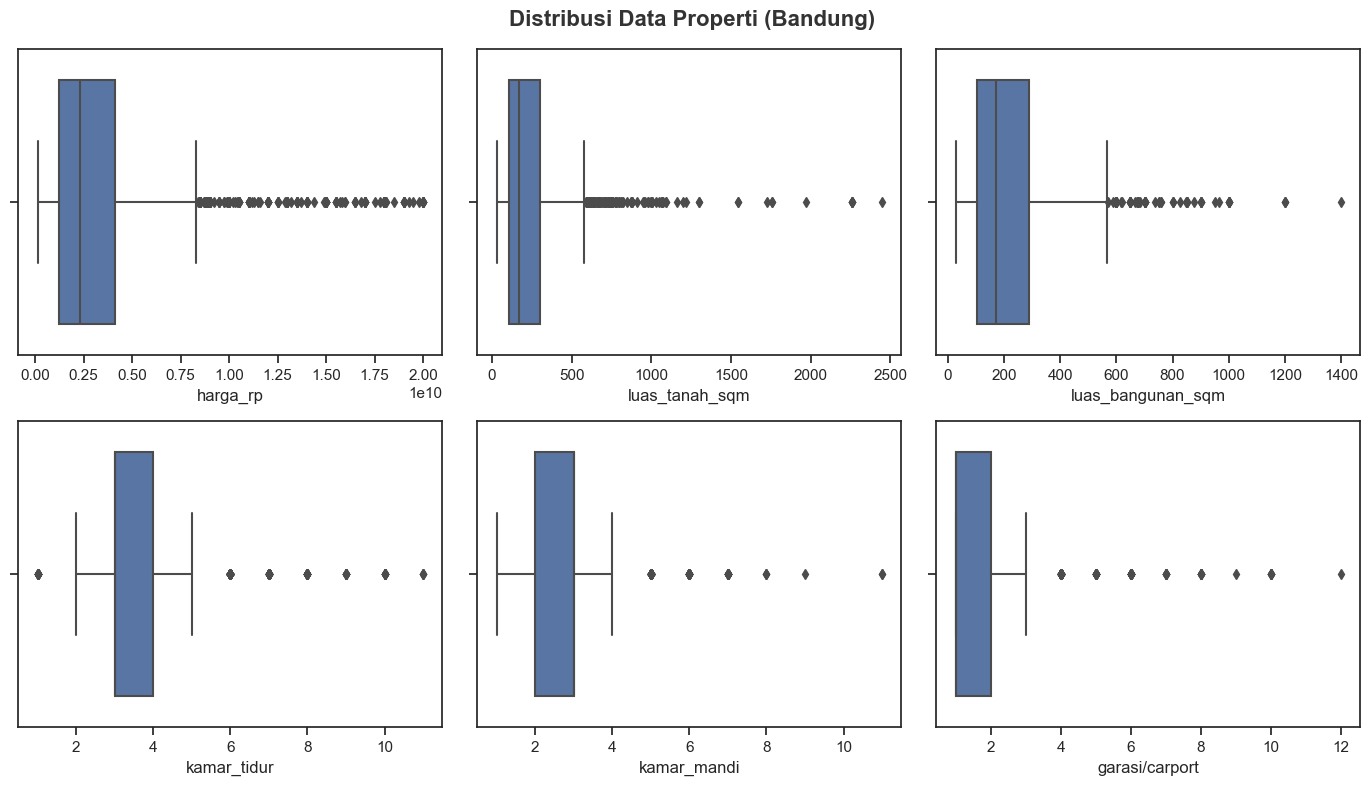

In [48]:
sns.set_theme(style="ticks")

fig, axes = plt.subplots(2, 3, figsize=(14, 8))
columns = ['harga_rp','luas_tanah_sqm','luas_bangunan_sqm','kamar_tidur','kamar_mandi','garasi/carport']

for i, col in enumerate(columns):
    row = i // 3 
    col_idx = i % 3 
    sns.boxplot(df_clean[col], ax=axes[row, col_idx])

fig.suptitle("Distribusi Data Properti (Bandung)", fontsize=16, fontweight="bold", color="#333333")
plt.tight_layout()
plt.show()

Outlier tidak di hilangkan untuk menjaga relevansi dan mereperesntasikan keadaan sebenarnya

In [49]:
df_clean['kecamatan'].unique()

array(['Sukasari', 'Bojongloa Kaler', 'Sumur Bandung', 'Sukajadi',
       'Buah Batu', 'Astana Anyar', 'Gedebage', 'Lengkong', 'Cicendo',
       'Batununggal', 'Cibiru', 'Bojongloa Kidul', 'Kiaracondong',
       'Coblong', 'Antapani', 'Arcamanik', 'Cibeunying Kidul',
       'Bandung Kulon', 'Rancasari', 'Cidadap', 'Ujungberung',
       'Cibeunying Kaler', 'Regol', 'Babakan Ciparay', 'Andir',
       'Bandung Kidul', 'Bandung Wetan', 'Mandalajati', 'Panyileukan'],
      dtype=object)

In [50]:
wilayah_dict = {
    "Bandung Barat": ["Sukajadi", "Cidadap", "Cicendo", "Bandung Kulon"],
    "Bandung Timur": ["Cibiru", "Ujungberung", "Panyileukan", "Arcamanik", "Antapani", "Gedebage", "Mandalajati", "Rancasari"],
    "Bandung Utara": ["Coblong", "Cibeunying Kaler", "Cibeunying Kidul", "Sukasari"],
    "Bandung Selatan": ["Buah Batu", "Bojongloa Kidul", "Bojongloa Kaler", "Babakan Ciparay", "Bandung Kidul", "Regol"],
    "Bandung Tengah": ["Sumur Bandung", "Lengkong", "Astana Anyar", "Batununggal", "Kiaracondong", "Bandung Wetan", "Andir"]
}

In [51]:
def wilayah(kecamatan):
    for wilayah, kecamatan_list in wilayah_dict.items():
        if kecamatan in kecamatan_list:
            return wilayah
    return None

In [52]:
df_clean['wilayah'] = df_clean.apply(
    lambda row: wilayah(row['kecamatan']) if not pd.isna(row['kecamatan']) else row['wilayah'],
    axis=1)

In [53]:
df_clean['wilayah'].value_counts()

Bandung Tengah     603
Bandung Utara      573
Bandung Selatan    476
Bandung Timur      450
Bandung Barat      200
Name: wilayah, dtype: int64

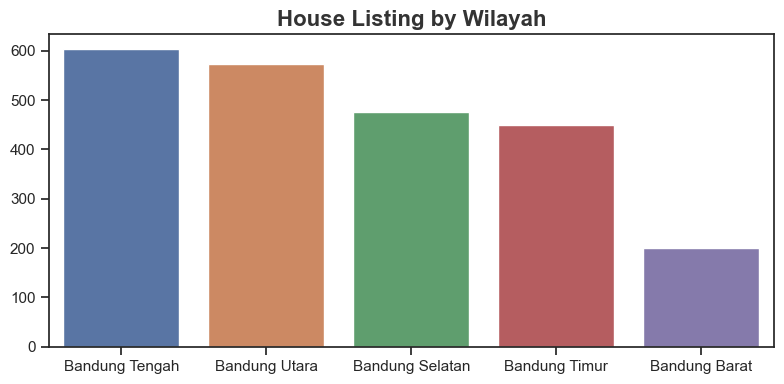

In [54]:
plt.figure(figsize=(8,4))
sns.barplot(x = df_clean['wilayah'].value_counts().index,
            y = df_clean['wilayah'].value_counts().values)

plt.title('House Listing by Wilayah', fontsize=16, fontweight="bold", color="#333333")
plt.tight_layout()
plt.show()

Bandung Tengah menjadi wilayah yang paling banyak rumah di iklankan. sebaliknya Bandung Barat menjadi wilayah yang jumlah rumah di iklankan paling sedikit

In [55]:
df_clean['wilayah'].value_counts(normalize=True) * 100

Bandung Tengah    26
Bandung Utara     25
Bandung Selatan   21
Bandung Timur     20
Bandung Barat      9
Name: wilayah, dtype: float64

In [56]:
print('Jumlah rumah dijual di wilayah Bandung Barat:', df_clean[df_clean['wilayah'] == 'Bandung Barat']['id_listing'].count())

Jumlah rumah dijual di wilayah Bandung Barat: 200


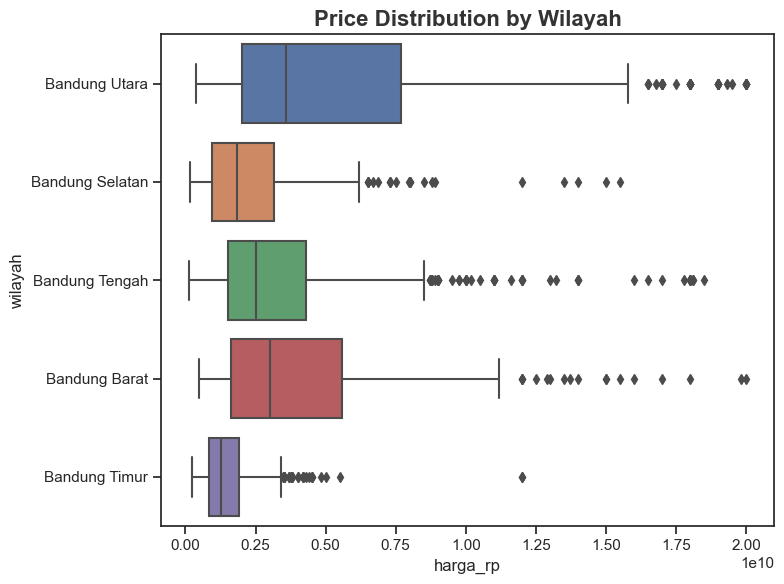

In [57]:
plt.figure(figsize=(8,6))
ax = sns.boxplot(data = df_clean, x = 'harga_rp', y='wilayah')

plt.title('Price Distribution by Wilayah', fontsize=16, fontweight="bold", color="#333333")
plt.tight_layout()
plt.show()

Bandung Utara menjadi wilayah dengan median harga rumah paling tinggi di kota Bandung.

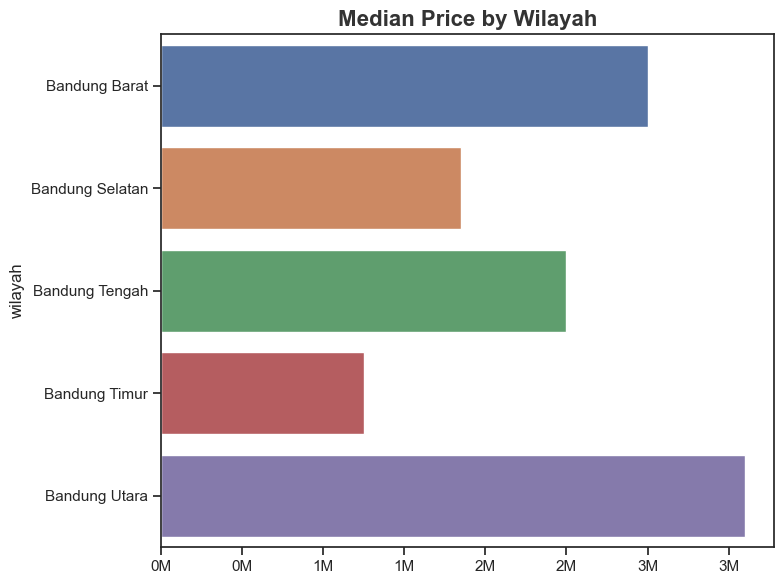

In [58]:
plt.figure(figsize=(8,6))
ax = sns.barplot(y = df_clean.groupby('wilayah')['harga_rp'].median().index,
            x = df_clean.groupby('wilayah')['harga_rp'].median().values)

ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{int(x/1e9)}M"))
plt.title('Median Price by Wilayah', fontsize=16, fontweight="bold", color="#333333")
plt.tight_layout()
plt.show()

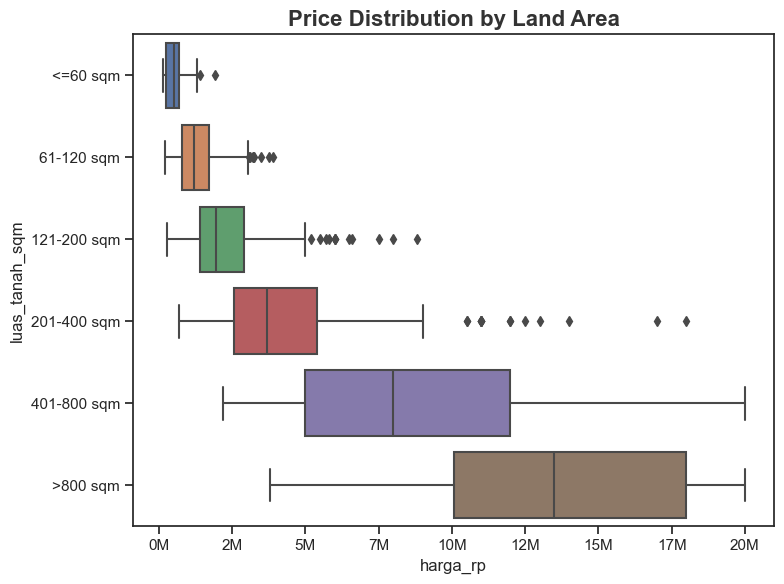

In [59]:
plt.figure(figsize=(8,6))
bins = [0, 60, 120, 200, 400, 800, float('inf')]
labels = ["<=60 sqm", "61-120 sqm", "121-200 sqm", "201-400 sqm", "401-800 sqm", ">800 sqm"]

ax = sns.boxplot(y = pd.cut(df_clean["luas_tanah_sqm"], bins=bins, labels=labels),
            x = df_clean['harga_rp'])

ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{int(x/1e9)}M"))
plt.title('Price Distribution by Land Area', fontsize=16, fontweight="bold", color="#333333")
plt.tight_layout()
plt.show()

In [60]:
bins = [0, 60, 120, 200, 400, 800, float('inf')]
labels = ["<=60 sqm", "61-120 sqm", "121-200 sqm", "201-400 sqm", "401-800 sqm", ">800 sqm"]
df_temp = df_clean.copy()

df_temp['segment_lt'] = pd.cut(df_temp['luas_tanah_sqm'], bins=bins, labels=labels)
median_by_wilayah_larea = df_temp.groupby(['wilayah', 'segment_lt'])['harga_rp'].median().reset_index()
median_by_wilayah_larea.sort_values(by='harga_rp')

,wilayah,segment_lt,harga_rp
6,Bandung Selatan,<=60 sqm,287500000
12,Bandung Tengah,<=60 sqm,472500000
18,Bandung Timur,<=60 sqm,500000000
24,Bandung Utara,<=60 sqm,795000000
0,Bandung Barat,<=60 sqm,817500000
19,Bandung Timur,61-120 sqm,948000000
7,Bandung Selatan,61-120 sqm,1150000000
13,Bandung Tengah,61-120 sqm,1300000000
1,Bandung Barat,61-120 sqm,1400000000
20,Bandung Timur,121-200 sqm,1450000000


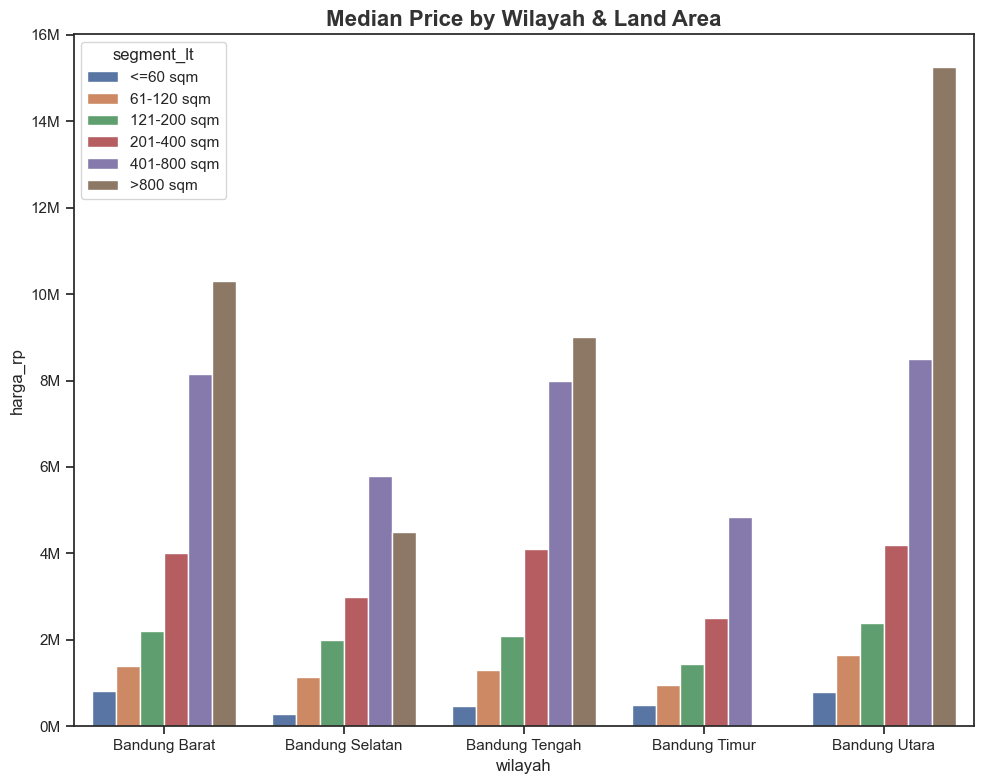

In [61]:
plt.figure(figsize=(10,8))
ax = sns.barplot(data=median_by_wilayah_larea, x='wilayah', y='harga_rp', hue='segment_lt')

ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{int(x/1e9)}M"))
plt.title('Median Price by Wilayah & Land Area', fontsize=16, fontweight="bold", color="#333333")
plt.tight_layout()
plt.show()

In [62]:
df_temp[(df_temp['wilayah'] == 'Bandung Timur') | (df_temp['wilayah'] == 'Bandung Utara')].groupby(['wilayah','segment_lt'])['harga_rp'].median().reset_index().iloc[[2,7]]

,wilayah,segment_lt,harga_rp
2,Bandung Timur,121-200 sqm,1450000000
7,Bandung Utara,61-120 sqm,1650000000


In [63]:
#hitung perbedaan persentase
((1450000000 - 1650000000) / 1650000000) * 100

-12.121212121212121

Median harga rumah dengan luas tanah 121–200sqm di Bandung Timur lebih murah 12% (sekitar Rp200 juta) dibandingkan rumah dengan luas tanah 61–120sqm di Bandung Utara.

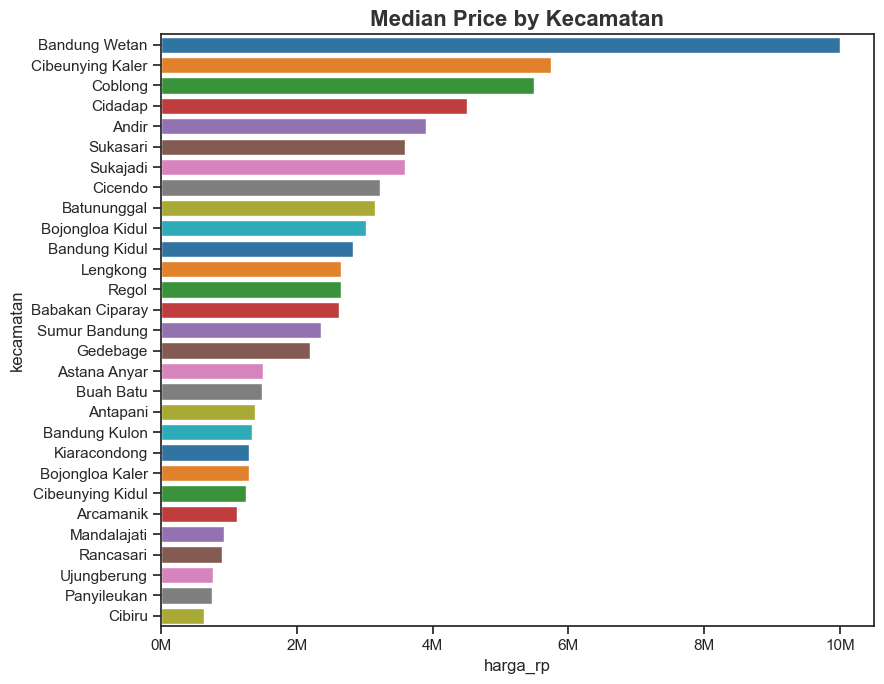

In [64]:
plt.figure(figsize=(9,7))
ax = sns.barplot(data = df_clean.groupby('kecamatan')['harga_rp'].median().reset_index().sort_values(by='harga_rp', ascending=False) ,
            x = 'harga_rp', y = 'kecamatan', palette="tab10")

ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{int(x/1e9)}M"))
plt.title('Median Price by Kecamatan', fontsize=16, fontweight="bold", color="#333333")
plt.tight_layout()
plt.show()

- Cibiru, Panyileukan, Ujungberung menjadi kecamatan dengan Harga rumah yang paling terjangkau-  Bandung Wetan, Cibeunying Kaler, dan Coblong menjadi kecamatan dengan Harga rumah sangat tinggi

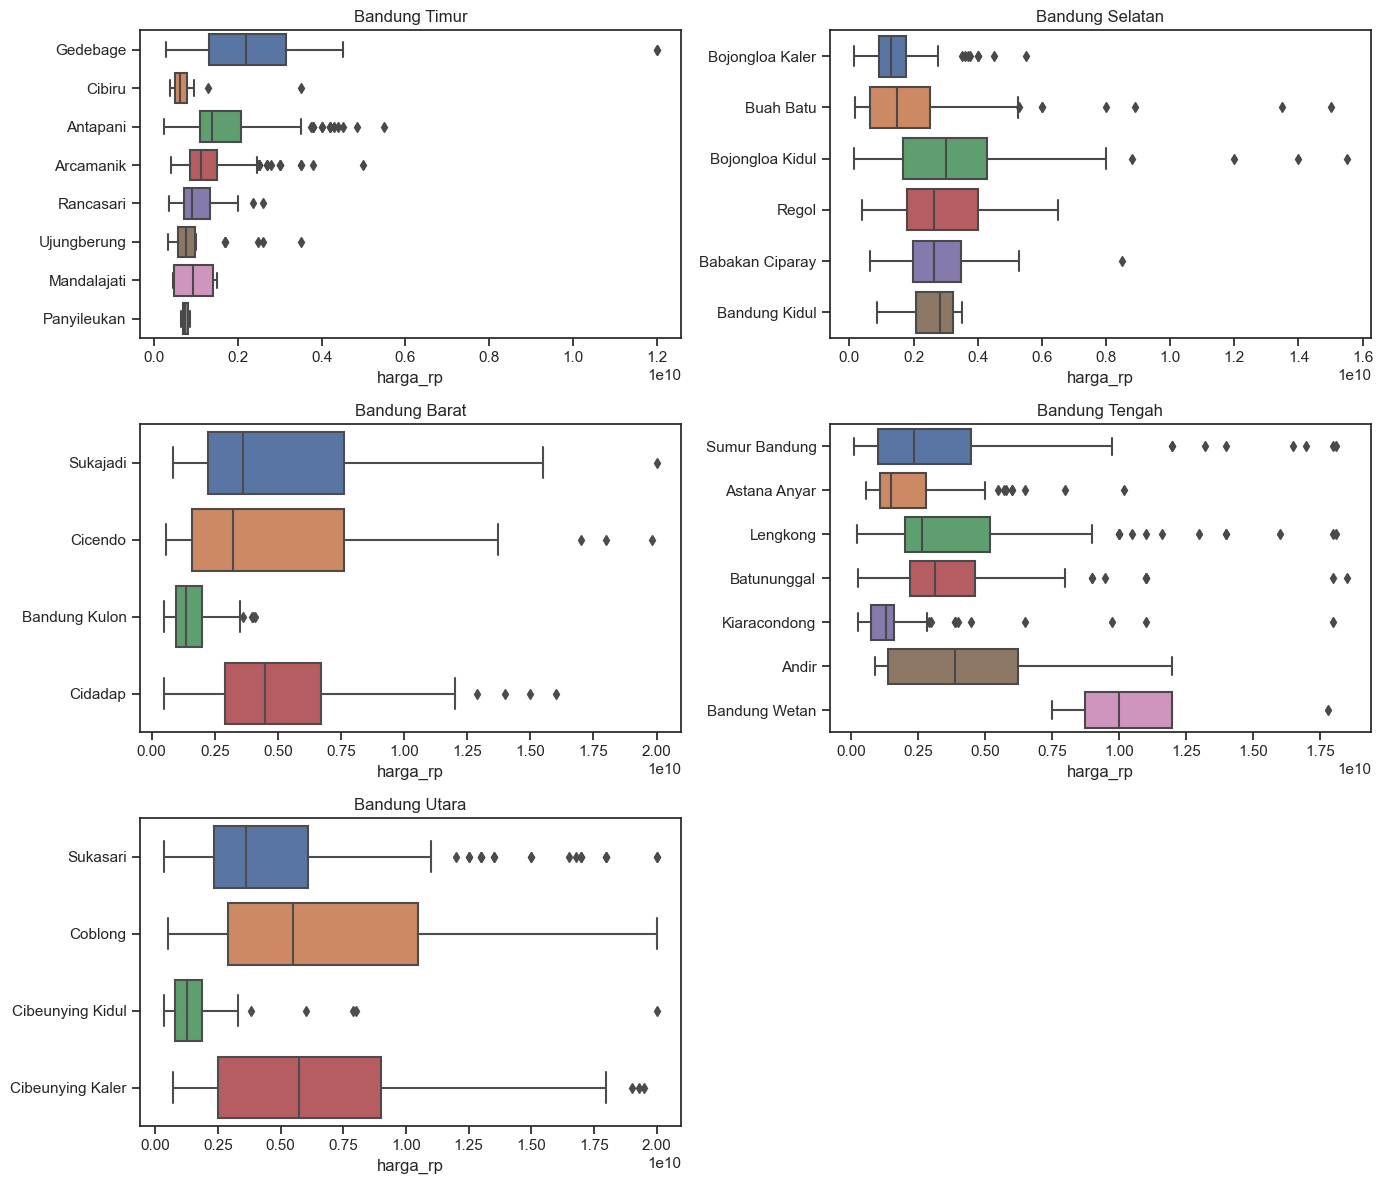

In [65]:
fig, axes = plt.subplots(3, 2, figsize=(14, 12))

sns.boxplot(data = df_clean[df_clean['wilayah'] == 'Bandung Timur'], x = 'harga_rp', y ='kecamatan', ax=axes[0,0])
sns.boxplot(data = df_clean[df_clean['wilayah'] == 'Bandung Selatan'], x = 'harga_rp', y ='kecamatan', ax=axes[0,1])
sns.boxplot(data = df_clean[df_clean['wilayah'] == 'Bandung Barat'], x = 'harga_rp', y ='kecamatan', ax=axes[1,0])
sns.boxplot(data = df_clean[df_clean['wilayah'] == 'Bandung Tengah'], x = 'harga_rp', y ='kecamatan', ax=axes[1,1])
sns.boxplot(data = df_clean[df_clean['wilayah'] == 'Bandung Utara'], x = 'harga_rp', y ='kecamatan', ax=axes[2,0])

axes[0, 0].set_title('Bandung Timur')
axes[0, 1].set_title('Bandung Selatan')
axes[1, 0].set_title('Bandung Barat')
axes[1, 1].set_title('Bandung Tengah')
axes[2, 0].set_title('Bandung Utara')

axes[0, 0].set_ylabel('')
axes[0, 1].set_ylabel('')
axes[1, 0].set_ylabel('')
axes[1, 1].set_ylabel('')
axes[2, 0].set_ylabel('')

fig.delaxes(axes[2, 1])

plt.tight_layout()
plt.show()

In [66]:
#mencari variasi harga rumah berdasarkan kecamatan menggunakan IQR agar tidak terpengaruh oleh outlier
df_clean.groupby('kecamatan')['harga_rp'].agg(
    median = lambda x: x.median(),
    IQR = lambda x: x.quantile(0.75) - x.quantile(0.25)
).reset_index().sort_values(by='IQR')

,kecamatan,median,IQR
22,Panyileukan,750000000,100000000
14,Cibiru,630000000,295000000
28,Ujungberung,760000000,392000000
23,Rancasari,900000000,621000000
2,Arcamanik,1115000000,650000000
19,Kiaracondong,1300000000,835000000
9,Bojongloa Kaler,1300000000,862500000
21,Mandalajati,925000000,937500000
1,Antapani,1390000000,975000000
6,Bandung Kulon,1340000000,1050000000


- Median Harga paling tinggi di Bandung utara berada pada kecamatan Cibeunying Kaler, yaitu di angka 5.75M
- Kecamatan Coblong, Cibeunying Kaler, dan Cicendo menjadi kecamatan dengan Harga rumah yang cukup bervariasi dari yang murah hingga sangat mahal

#### Insight
1. Cibiru, Panyileukan, dan Ujungberung merupakan kecamatan dengan harga rumah paling terjangkau di Bandung.
1. Bandung Wetan, Cibeunying Kaler, dan Coblong menjadi kecamatan dengan harga rumah tertinggi di Bandung.
1. Bandung Barat memiliki jumlah rumah yang diiklankan paling sedikit, yaitu 200 dari total 2.302 rumah (sekitar 9% dari keseluruhan listing).
1. Bandung Utara memiliki median harga rumah tertinggi, sedangkan Bandung Timur memiliki median harga rumah terendah.
1. Menariknya, meskipun jumlah rumah yang diiklankan di Bandung Barat paling sedikit, median harganya justru menempati posisi kedua tertinggi setelah Bandung Utara.
1. Median harga rumah dengan luas tanah 121–200sqm di Bandung Timur lebih murah 12% (sekitar Rp200 juta) dibandingkan rumah dengan luas tanah 61–120sqm di Bandung Utara.
1. Terdapat anomali pada median harga rumah dengan luas tanah >800sqm di Bandung Selatan, yang justru lebih murah dibandingkan rumah dengan luas tanah 401–800sqm di seluruh wilayah Kota Bandung.
1. Kecamatan Cibeunying Kaler memiliki median harga rumah tertinggi di Bandung Utara, yang merupakan wilayah dengan median harga rumah tertinggi di 1. Kota Bandung, dengan angka mencapai Rp5,75 miliar.
1. Kecamatan Coblong, Cibeunying Kaler, dan Cicendo memiliki variasi harga rumah yang cukup luas, mencakup segmen harga rendah hingga tinggi.


### Segmentasi Pasar
- Low-end (< Rp500 juta)
- Affordable (Rp500 juta – Rp1,5 miliar)
- Mid-range (Rp1,5 miliar – Rp3 miliar)
- High-end (Rp3 miliar – Rp7 miliar)
- Luxury (> Rp7 miliar)

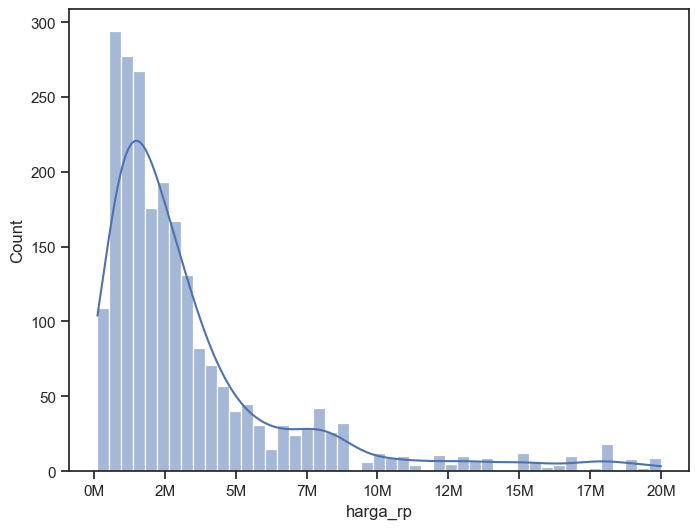

In [67]:
plt.figure(figsize=(8,6))
ax = sns.histplot(df_clean['harga_rp'], kde=True)

ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{int(x/1e9)}M"))
plt.show()

In [68]:
def segment_price(price):
    if price < 500_000_000:
        return "<500 Juta"
    elif 500_000_000 <= price < 1_500_000_000:
        return "500 juta-1.5M"
    elif 1_500_000_000 <= price < 3_000_000_000:
        return "1.5-3M"
    elif 3_000_000_000 <= price < 7_000_000_000:
        return "3-7M"
    else:
        return ">7M"

def segment_LT(lt):
    if lt < 60:
        return "<60sqm"
    elif 60 <= lt < 120:
        return "60-120sqm"
    elif 120 <= lt < 200:
        return "120-200sqm"
    elif 200 <= lt < 400:
        return "200-400sqm"
    elif 400 <= lt < 800:
        return "400-800sqm"
    else:
        return ">800sqm"

In [69]:
df_clean['segmen_harga'] = df_clean['harga_rp'].apply(segment_price)
df_clean['segmen_lt'] = df_clean['luas_tanah_sqm'].apply(segment_LT)
df_clean.sample(5)

,id_listing,judul,harga,alamat,kamar_tidur,kamar_mandi,garasi/carport,harga_rp,luas_tanah_sqm,luas_bangunan_sqm,kecamatan,wilayah,segmen_harga,segmen_lt
69,hos18432726,Rumah Minimalis Cantik Bali Garden City View,"Rp 1,32 Miliar","Bandung Kota, Bandung",3,2,2,1320000000,100,75,Sumur Bandung,Bandung Tengah,500 juta-1.5M,60-120sqm
1002,hos18732306,Dijual Cepat Rumah Luas 324 M2 Di Jalan Sunda ...,"Rp 10,5 Miliar","Lengkong, Bandung",6,2,4,10500000000,324,228,Lengkong,Bandung Tengah,>7M,200-400sqm
778,hos18697380,Dijual Cepat Rumah Mewah Harga Muraaah di Komp...,Rp 12 Miliar,"Setra Duta, Bandung",5,4,4,12000000000,714,600,Sukasari,Bandung Utara,>7M,400-800sqm
1925,hos17706693,Ruko Strategis Gatot Subroto Bandung Kota Loka...,Rp 11 Miliar,"Gatot Subroto, Bandung",4,2,4,11000000000,512,200,Lengkong,Bandung Tengah,>7M,400-800sqm
1604,hos18948100,Jual Rumah Di Sherwood Tki V,"Rp 1,3 Miliar","Kopo, Bandung",2,1,1,1300000000,114,45,Bojongloa Kaler,Bandung Selatan,500 juta-1.5M,60-120sqm


In [70]:
df_clean['segmen_harga'].value_counts()

1.5-3M           720
500 juta-1.5M    640
3-7M             539
>7M              312
<500 Juta         91
Name: segmen_harga, dtype: int64

In [71]:
df_clean['segmen_lt'].value_counts()

60-120sqm     671
120-200sqm    632
200-400sqm    601
400-800sqm    322
>800sqm        50
<60sqm         26
Name: segmen_lt, dtype: int64

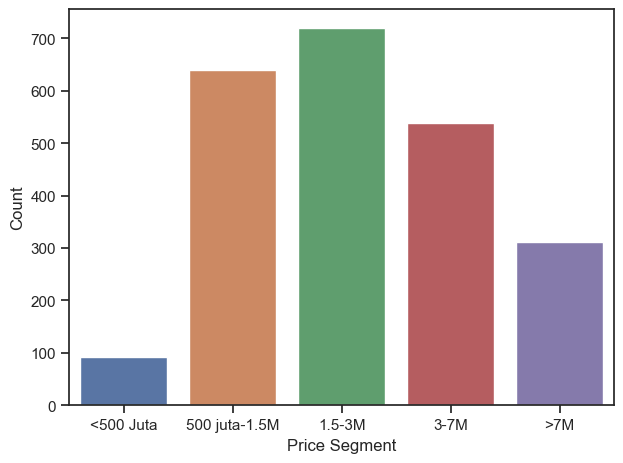

In [72]:
price_order = ["<500 Juta", "500 juta-1.5M", "1.5-3M", "3-7M", ">7M"]
sns.barplot(data = df_clean['segmen_harga'].value_counts().reset_index() , x = 'index', y = 'segmen_harga', order=price_order)

plt.xlabel('Price Segment')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

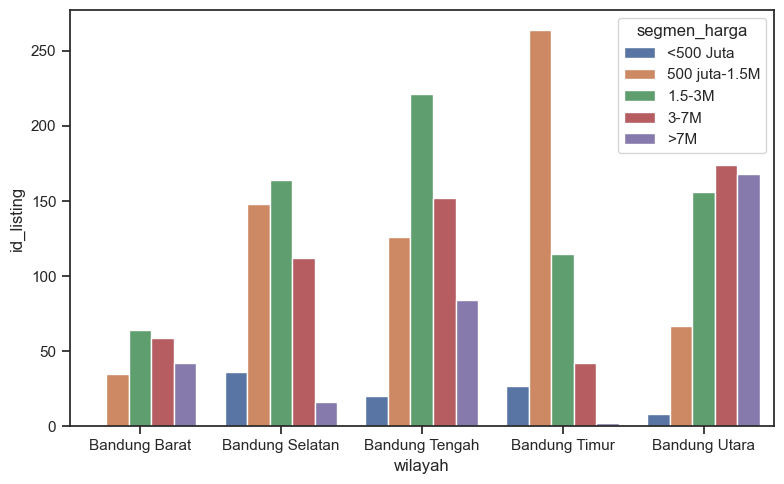

In [73]:
plt.figure(figsize=(8,5))
sns.barplot(data = df_clean.groupby(['wilayah', 'segmen_harga']).count().reset_index(),
            x = 'wilayah', y = 'id_listing', hue = 'segmen_harga', hue_order=price_order)

plt.tight_layout()
plt.show()

- Bandung Utara di dominasi rumah segmen High end (Rp 3-7 Miliar)
- Bandung Timur di dominasi rumah affdorable (Rp 500 juta - 1.5 Miliar)

In [74]:
segmen_wilayah = df_clean.groupby(['wilayah', 'segmen_harga']).size().unstack()
segmen_wilayah_percentage = segmen_wilayah.div(segmen_wilayah.sum(axis=1), axis=0) * 100

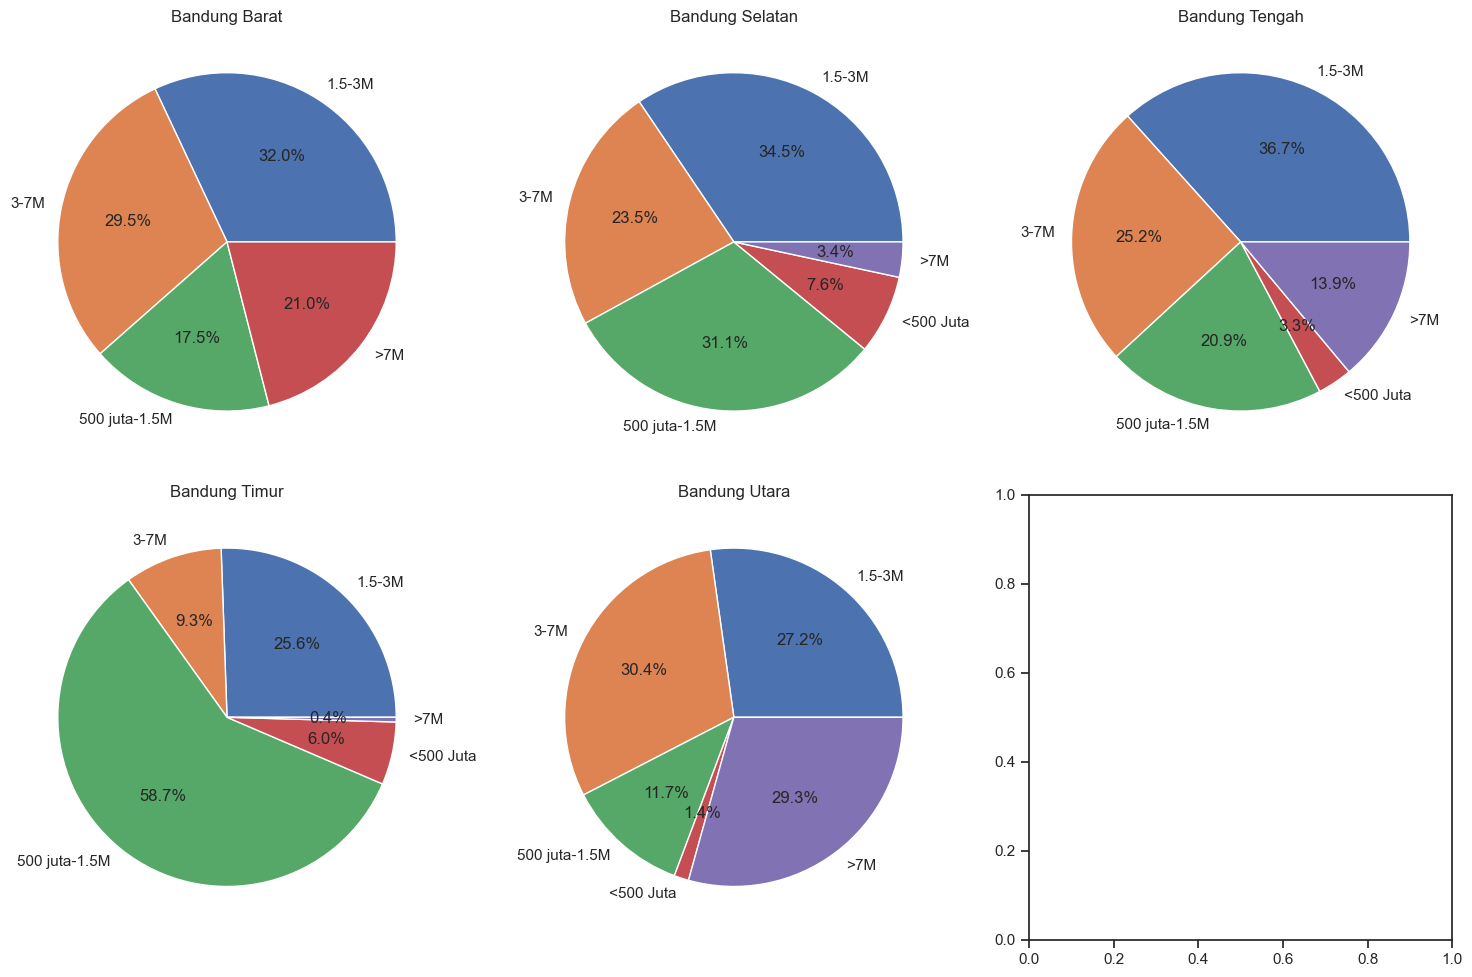

In [75]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, wilayah in enumerate(segmen_wilayah_percentage.index):
    ax = axes[i]
    data = segmen_wilayah_percentage.loc[wilayah].dropna()
    ax.pie(data, labels=data.index, autopct='%1.1f%%')
    ax.set_title(f"{wilayah}")

plt.tight_layout()
plt.show()



- Bandung Utara menjadi wilayah yang paling banyak rumah dengan harga lebih dari 7 Miliar.
- Wilayah Bandung Timur mendominasi untuk rumah dengan harga standard di angka 500 juta - 1.5M

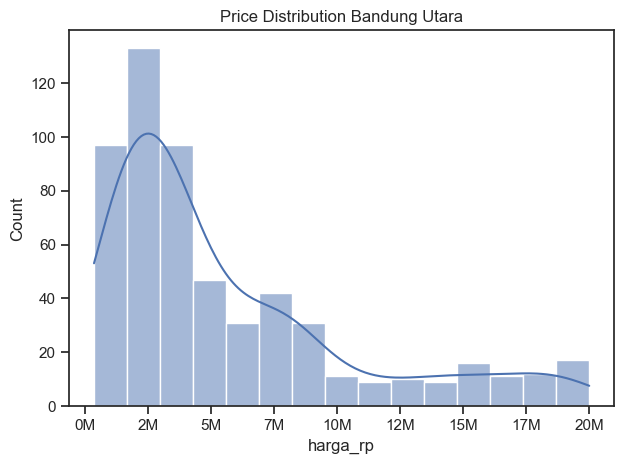

In [76]:
ax = sns.histplot(df_clean[df_clean['wilayah'] == 'Bandung Utara']['harga_rp'], kde=True)

ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{int(x/1e9)}M"))

plt.title('Price Distribution Bandung Utara')
plt.tight_layout()
plt.show()

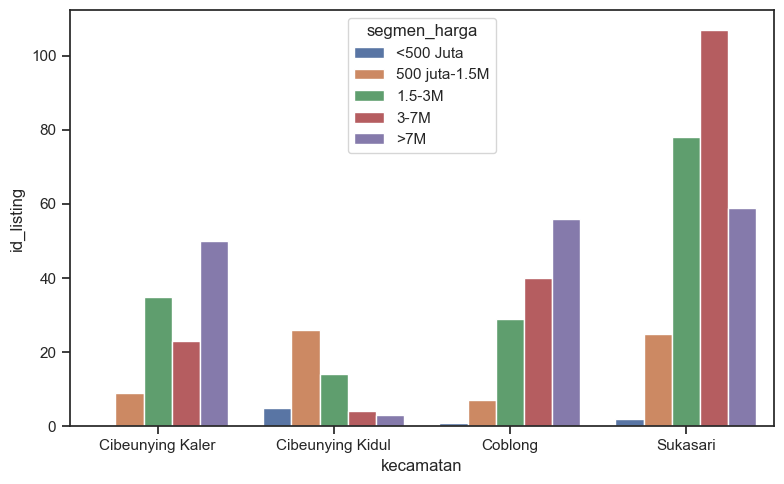

In [77]:
plt.figure(figsize=(8,5))
sns.barplot(data = df_clean[df_clean['wilayah'] == 'Bandung Utara'].groupby(['kecamatan', 'segmen_harga']).count().reset_index(),
            x = 'kecamatan', y = 'id_listing', hue = 'segmen_harga', hue_order=price_order)

plt.tight_layout()
plt.show()

- Kecamatan Sukasari menjadi kecamatan yang paling banyak memiliki hunian mewah harga diatas 7 Miliar
- Dari 4 kecamatan di Bandung Utara, 3 Kecamatan diantaranya di dominasi oleh hunian rumah mewah dengan harga 3-7 Miliar dan lebih dari 7 Miliar
- Menariknya kecamatan Cibeunying Kidul justru di dominasi oleh rumah dengan kisaran harga 500 juta - 1.5 Miliar, berbeda jauh dengan 3 kecamatan lainnya yang di dominasi rumah mewah dengan harga tinggi

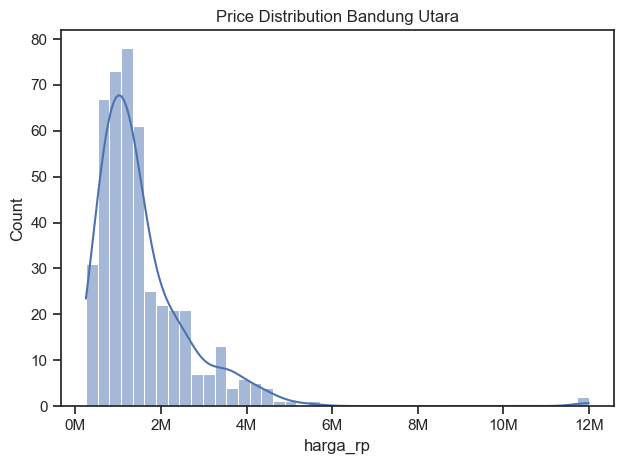

In [78]:
ax = sns.histplot(df_clean[df_clean['wilayah'] == 'Bandung Timur']['harga_rp'], kde=True)

ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{int(x/1e9)}M"))

plt.title('Price Distribution Bandung Utara')
plt.tight_layout()
plt.show()

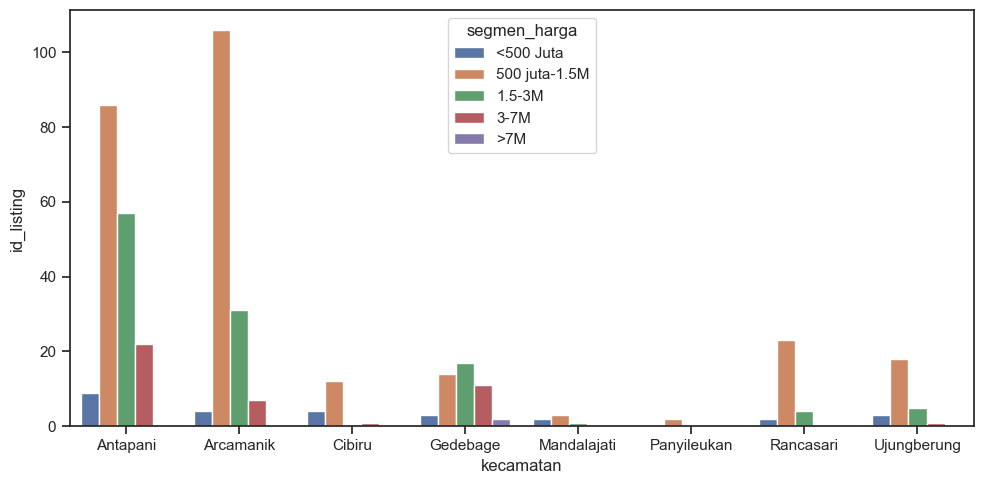

In [79]:
plt.figure(figsize=(10,5))
sns.barplot(data = df_clean[df_clean['wilayah'] == 'Bandung Timur'].groupby(['kecamatan', 'segmen_harga']).count().reset_index(),
            x = 'kecamatan', y = 'id_listing', hue = 'segmen_harga', hue_order=price_order)

plt.tight_layout()
plt.show()

- Kecamatan Antapani dan Arcamnanik menjadi penyumbang terbanyak untuk rumah hunian dengan harga 500 juta - 1.5 Miliar

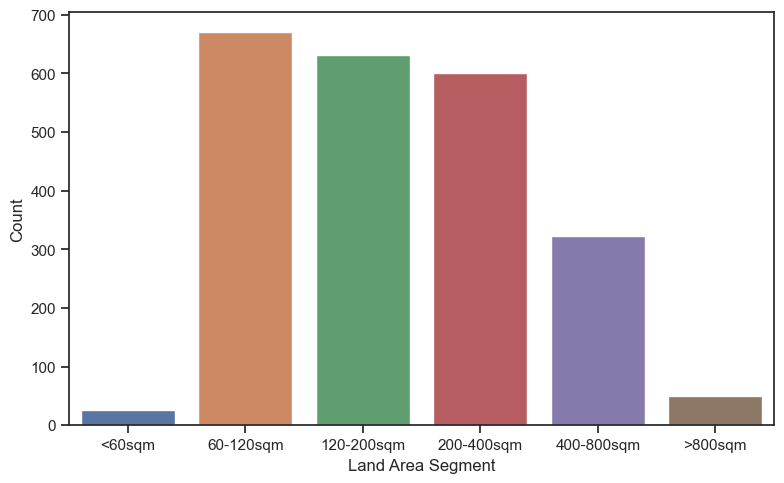

In [80]:
plt.figure(figsize=(8,5))
order_LT = ["<60sqm", "60-120sqm", "120-200sqm", "200-400sqm", "400-800sqm", ">800sqm"]
sns.barplot(data = df_clean['segmen_lt'].value_counts().reset_index() , x = 'index', y = 'segmen_lt', order=order_LT)

plt.xlabel('Land Area Segment')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

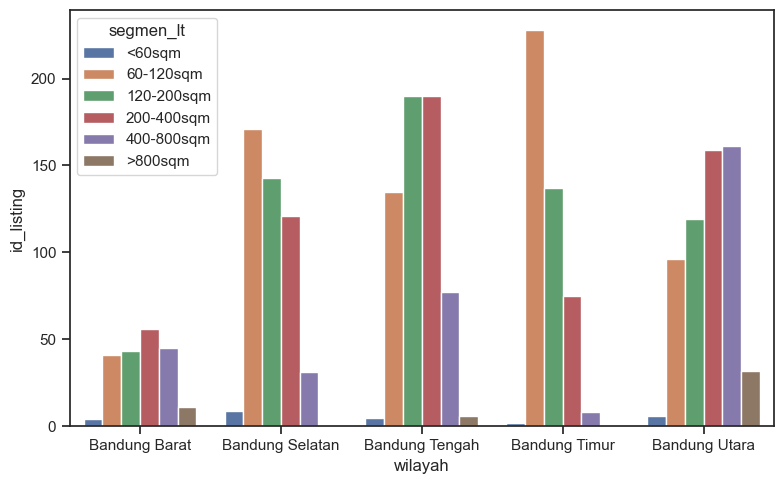

In [81]:
plt.figure(figsize=(8,5))
sns.barplot(data = df_clean.groupby(['wilayah', 'segmen_lt']).count().reset_index(),
            x = 'wilayah', y = 'id_listing', hue = 'segmen_lt', hue_order=order_LT)

plt.tight_layout()
plt.show()

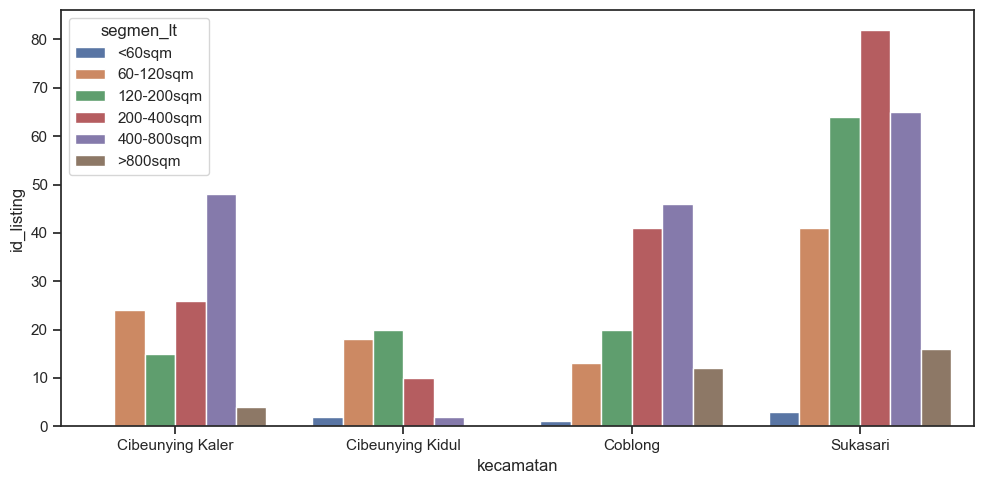

In [82]:
plt.figure(figsize=(10,5))
sns.barplot(data = df_clean[df_clean['wilayah'] == 'Bandung Utara'].groupby(['kecamatan', 'segmen_lt']).count().reset_index(),
            x = 'kecamatan', y = 'id_listing', hue = 'segmen_lt', hue_order=order_LT)

plt.tight_layout()
plt.show()

- Bandung Utara dan juga kecamatannya Sukasari juga menjadi wilayah dengan rumah yang luas tanahnya paling besar
- Luas tanah ini bisa menjadi salah satu penyebab harga rumah di Bandung Utara ini kenapa sangat tinggi. Ini akan di analisis lebih lanjut di bagian selanjutnya

#### Insight
1. Bandung Utara menjadi wilayah yang di dominasi rumah di segmen harga tinggi. Sebanyak 60% dari total rumah yang diiklankan di wilayah ini berada di kisaran Rp3–7 miliar dan di atas Rp7 miliar, masing-masing dengan porsi 30%
1. Bandung Timur mendominasi segmen rumah dengan harga standar di kisaran Rp500 juta – Rp1,5 miliar.
1. Kecamatan Sukasari menjadi kecamatan dengan jumlah hunian mewah (harga > Rp7 miliar) terbanyak di wilayah Bandung Utara.
1. Dari empat kecamatan di Bandung Utara, tiga di antaranya didominasi oleh rumah mewah dengan harga Rp3–7 miliar dan di atas Rp7 miliar.
1. Menariknya, Kecamatan Cibeunying Kidul justru didominasi oleh rumah dengan harga Rp500 juta – Rp1,5 miliar, berbeda jauh dengan tiga kecamatan lain di Bandung Utara yang lebih banyak memiliki hunian mewah dengan harga tinggi.
1. Kecamatan Antapani dan Arcamanik menjadi penyumbang terbesar untuk segmen rumah dengan harga standar Rp500 juta – Rp1,5 miliar.

### Faktor Apa yang Berpengaruh Terhadap Harga Rumah?

In [83]:
from geopy.geocoders import Nominatim
from geopy.distance import geodesic

import time

In [84]:
geolocator = Nominatim(user_agent="kecamatan_bandung", timeout=10)
geolocator.geocode("Ujungberung, Bandung, Indonesia")

Location(Ujungberung, Kota Bandung, Jawa Barat, Jawa, Indonesia, (-6.9053267, 107.710954740483, 0.0))

In [85]:
geolocator = Nominatim(user_agent="kecamatan_bandung", timeout=10)

In [86]:
list_kecamatan = df_clean['kecamatan'].unique()

dict_result = {}
for i in list_kecamatan:
    time.sleep(1)
    location = geolocator.geocode(f"{i}, Bandung, Indonesia")

    if location:
        dict_result[i] = (location.latitude, location.longitude)
    else:
        dict_result[i] = (None, None)
    print(i, location.latitude, location.longitude)

Sukasari -6.889291249999999 107.58870509879455
Bojongloa Kaler -6.93232645 107.59074740446374
Sumur Bandung -6.9143889000000005 107.61702181771668
Sukajadi -6.860296099999999 107.58906784137545
Buah Batu -6.9658122 107.63786605
Astana Anyar -6.9324654500000005 107.59881535095596
Gedebage -6.95285775 107.69811849128266
Lengkong -6.9343483 107.62621853326837
Cicendo -6.901484249999999 107.586982126197
Batununggal -6.928054100000001 107.6404417263918
Cibiru -6.915058950000001 107.72119143769423
Bojongloa Kidul -6.947036199999999 107.59627135374859
Kiaracondong -6.9247499 107.6462773
Coblong -6.880933349999999 107.61392108064138
Antapani -6.9178562 107.65988138469118
Arcamanik -6.92144665 107.6770158552717
Cibeunying Kidul -6.89851205 107.65007706308097
Bandung Kulon -6.93193445 107.55505327116754
Rancasari -6.9535356 107.67520978505222
Cidadap -6.8627967 107.60935594852518
Ujungberung -6.9053267 107.710954740483
Cibeunying Kaler -6.8863341 107.62897980161543
Regol -6.939712849999999 107.6

In [87]:
df_clean['latitude'] = df_clean['kecamatan'].map(lambda x: dict_result.get(x, (None, None))[0])
df_clean['longitude'] = df_clean['kecamatan'].map(lambda x: dict_result.get(x, (None, None))[1])

In [88]:
city_center_latlong = geolocator.geocode("Balai kota Bandung")

In [89]:
city_center = (city_center_latlong.latitude, city_center_latlong.longitude)
city_center

(-6.91096815, 107.61008306008654)

In [90]:
distance = {kecamatan: geodesic(city_center, koordinat).kilometers for kecamatan, koordinat in dict_result.items()}
distance

{'Sukasari': 3.36585794227589,
 'Bojongloa Kaler': 3.18516705679966,
 'Sumur Bandung': 0.8550776915375338,
 'Sukajadi': 6.066104314338012,
 'Buah Batu': 6.798064791241754,
 'Astana Anyar': 2.6837690045688016,
 'Gedebage': 10.77554355121142,
 'Lengkong': 3.140888419003103,
 'Cicendo': 2.760090389191757,
 'Batununggal': 3.85055719374926,
 'Cibiru': 12.287535725028,
 'Bojongloa Kidul': 4.270848069903425,
 'Kiaracondong': 4.2805206353984,
 'Coblong': 3.3485320421049023,
 'Antapani': 5.555941633643383,
 'Arcamanik': 7.487285725301484,
 'Cibeunying Kidul': 4.62971869767989,
 'Bandung Kulon': 6.508561013524286,
 'Rancasari': 8.600064312599317,
 'Cidadap': 5.327898429303921,
 'Ujungberung': 11.165448393440299,
 'Cibeunying Kaler': 3.432688422714628,
 'Regol': 3.2052741448433277,
 'Babakan Ciparay': 4.997328774808118,
 'Andir': 4.315765809635861,
 'Bandung Kidul': 5.475090414804201,
 'Bandung Wetan': 0.9715006968804855,
 'Mandalajati': 6.961004061851976,
 'Panyileukan': 10.69470639807353}

In [91]:
df_clean['jarak_pusat_kota(km)'] = df_clean['kecamatan'].map(lambda x: round(distance.get(x, 0), 2))

In [92]:
df_clean.groupby('kecamatan')['jarak_pusat_kota(km)'].max().reset_index().sort_values('jarak_pusat_kota(km)', ascending=False)

,kecamatan,jarak_pusat_kota(km)
14,Cibiru,12
28,Ujungberung,11
18,Gedebage,11
22,Panyileukan,11
23,Rancasari,9
2,Arcamanik,7
21,Mandalajati,7
11,Buah Batu,7
6,Bandung Kulon,7
25,Sukajadi,6


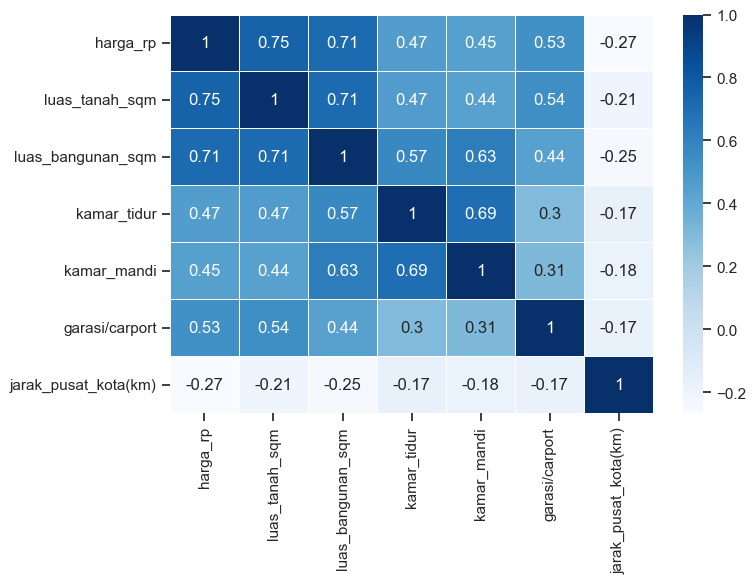

In [93]:
corr = df_clean[['harga_rp', 'luas_tanah_sqm', 'luas_bangunan_sqm', 'kamar_tidur', 'kamar_mandi','garasi/carport','jarak_pusat_kota(km)']].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, linewidths=0.5, cmap='Blues')

plt.tight_layout()
plt.show()

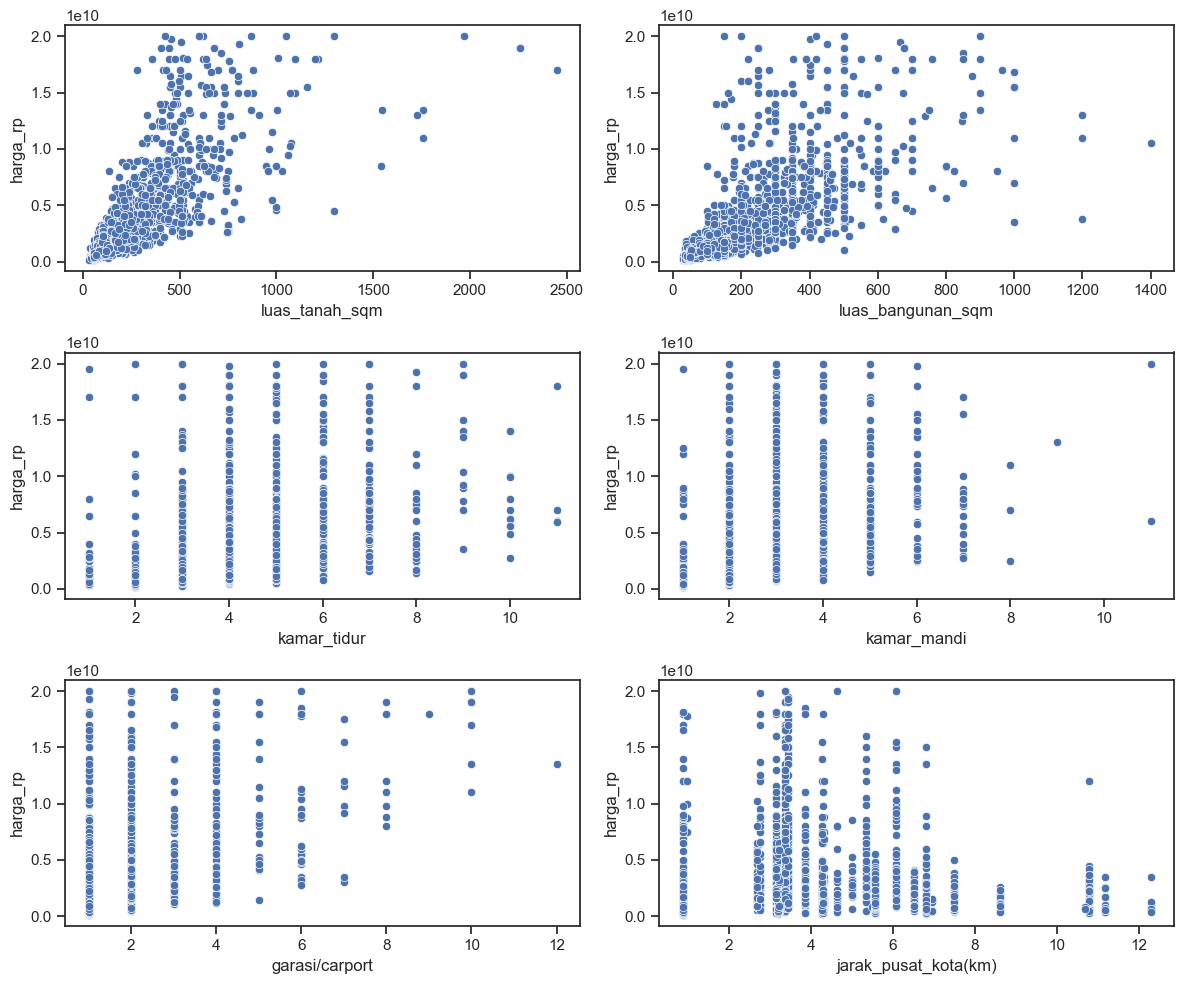

In [94]:
fig, axes = plt.subplots(3,2, figsize=(12,10))

sns.scatterplot(x=df_clean['luas_tanah_sqm'], y=df_clean['harga_rp'], ax=axes[0,0])
sns.scatterplot(x=df_clean['luas_bangunan_sqm'], y=df_clean['harga_rp'], ax=axes[0,1])
sns.scatterplot(x=df_clean['kamar_tidur'], y=df_clean['harga_rp'], ax=axes[1,0])
sns.scatterplot(x=df_clean['kamar_mandi'], y=df_clean['harga_rp'], ax=axes[1,1])
sns.scatterplot(x=df_clean['garasi/carport'], y=df_clean['harga_rp'], ax=axes[2,0])
sns.scatterplot(x=df_clean['jarak_pusat_kota(km)'], y=df_clean['harga_rp'], ax=axes[2,1])


plt.tight_layout()
plt.show()


In [95]:
df_grouped = df_clean.groupby('kecamatan').agg(
    luas_tanah_m2 = ('luas_tanah_sqm', 'median'),
    jarak_ke_pusat_kota_km = ('jarak_pusat_kota(km)', 'max'),
    median_harga = ('harga_rp', 'median')
).reset_index().sort_values(by='median_harga', ascending=False)

df_grouped

,kecamatan,luas_tanah_m2,jarak_ke_pusat_kota_km,median_harga
7,Bandung Wetan,437,1,10000000000
12,Cibeunying Kaler,363,3,5750000000
17,Coblong,350,3,5500000000
16,Cidadap,420,5,4500000000
0,Andir,223,4,3900000000
26,Sukasari,256,3,3600000000
25,Sukajadi,296,6,3600000000
15,Cicendo,204,3,3225000000
8,Batununggal,197,4,3150000000
10,Bojongloa Kidul,150,4,3025000000


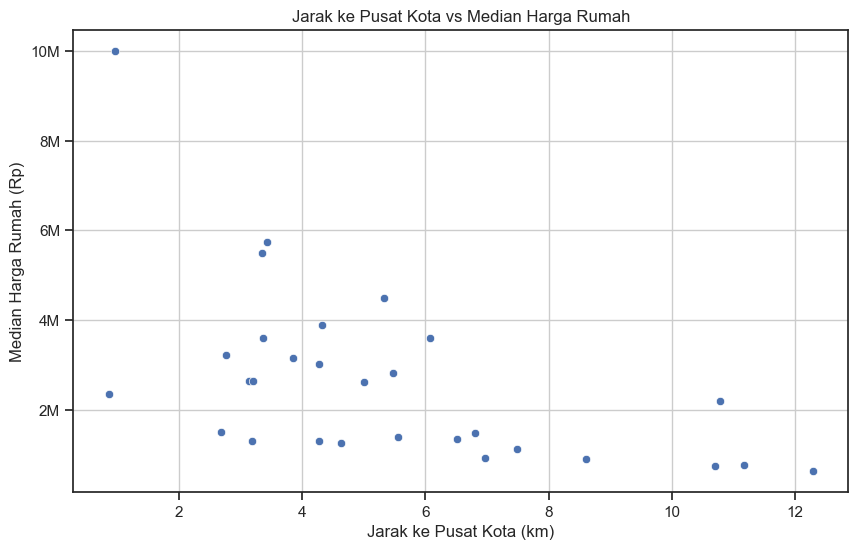

In [96]:
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(x=df_grouped['jarak_ke_pusat_kota_km'], y=df_grouped['median_harga'])
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{int(x/1e9)}M"))
plt.xlabel('Jarak ke Pusat Kota (km)')
plt.ylabel('Median Harga Rumah (Rp)')
plt.title('Jarak ke Pusat Kota vs Median Harga Rumah')
plt.grid(True)
plt.show()


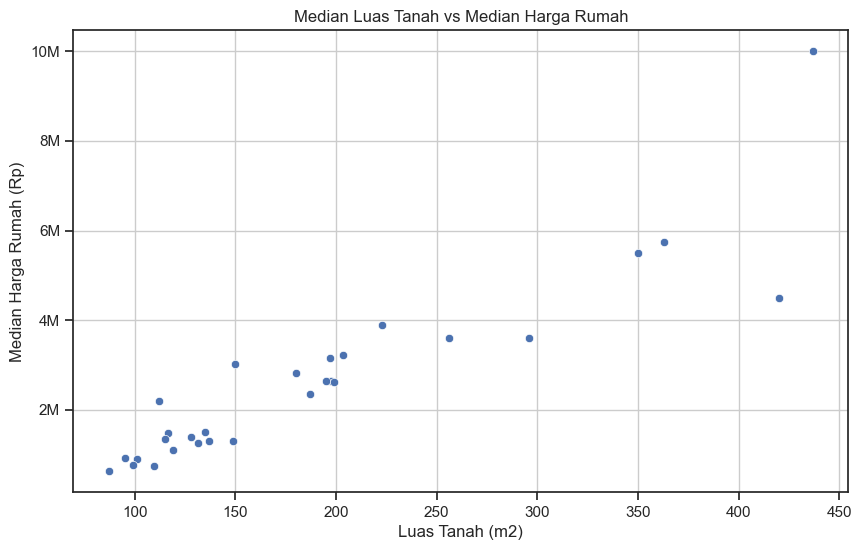

In [97]:
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(x=df_grouped['luas_tanah_m2'], y=df_grouped['median_harga'])
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{int(x/1e9)}M"))
plt.xlabel('Luas Tanah (m2)')
plt.ylabel('Median Harga Rumah (Rp)')
plt.title('Median Luas Tanah vs Median Harga Rumah')
plt.grid(True)
plt.show()


<AxesSubplot:>

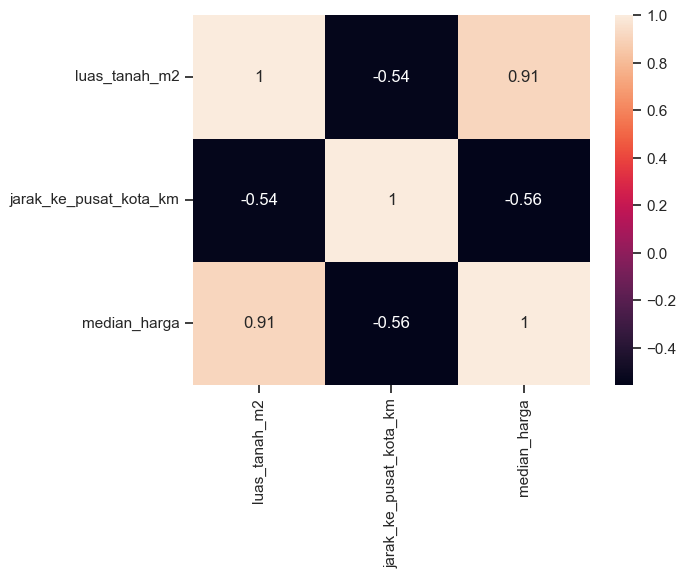

In [98]:
sns.heatmap(df_grouped.corr(), annot=True)

In [99]:
df_clean[df_clean['wilayah'] == 'Bandung Utara'].groupby('kecamatan').agg(
    jarak = ('jarak_pusat_kota(km)', 'max'),
    median_harga = ('harga_rp', 'median'),
    median_luas_tanah = ('luas_tanah_sqm', 'median')
)

,jarak,median_harga,median_luas_tanah
kecamatan,,,
Cibeunying Kaler,3,5750000000,363
Cibeunying Kidul,5,1250000000,132
Coblong,3,5500000000,350
Sukasari,3,3600000000,256


Harga rumah di Kecamatan Cibeunying Kidul lebih murah dibandingkan tiga kecamatan lain di Bandung Utara karena median luas tanah di kawasan ini lebih kecil. Selain itu, jarak Cibeunying Kidul ke pusat kota sedikit lebih jauh dibandingkan tiga kecamatan lainnya di Bandung Utara, yang kemungkinan turut mempengaruhi harga.

In [100]:
df_aggregat = df_clean.groupby("kecamatan").agg(
    median_luas_tanah=("luas_tanah_sqm", "median"),
    median_luas_bangunan=("luas_bangunan_sqm", "median"),
    jarak_ke_pusat_kota=("jarak_pusat_kota(km)", "max"),
    median_harga_rumah=("harga_rp", "median")
).reset_index()
df_aggregat

,kecamatan,median_luas_tanah,median_luas_bangunan,jarak_ke_pusat_kota,median_harga_rumah
0,Andir,223,383,4,3900000000
1,Antapani,128,103,6,1390000000
2,Arcamanik,119,120,7,1115000000
3,Astana Anyar,135,152,3,1500000000
4,Babakan Ciparay,199,210,5,2625000000
5,Bandung Kidul,180,202,5,2825000000
6,Bandung Kulon,115,164,7,1340000000
7,Bandung Wetan,437,300,1,10000000000
8,Batununggal,197,220,4,3150000000
9,Bojongloa Kaler,149,140,3,1300000000


In [101]:
find_outlier(df_clean, columns)

,column,lower_bound,upper_bound
0,harga_rp,-3024999998,8374999998
1,luas_tanah_sqm,-180,588
2,luas_bangunan_sqm,-176,569
3,kamar_tidur,2,6
4,kamar_mandi,0,4
5,garasi/carport,-0,4


In [102]:
df_no_outlier = df_clean[df_clean['harga_rp'] < 8374999998]

In [103]:
import statsmodels.api as sm

X = df_no_outlier["luas_tanah_sqm"]
y = df_no_outlier["harga_rp"]

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               harga_rp   R-squared:                       0.509
Model:                            OLS   Adj. R-squared:                  0.509
Method:                 Least Squares   F-statistic:                     2161.
Date:                Wed, 05 Mar 2025   Prob (F-statistic):          4.94e-324
Time:                        23:24:22   Log-Likelihood:                -46727.
No. Observations:                2086   AIC:                         9.346e+04
Df Residuals:                    2084   BIC:                         9.347e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             6.7e+08   4.93e+07     13.

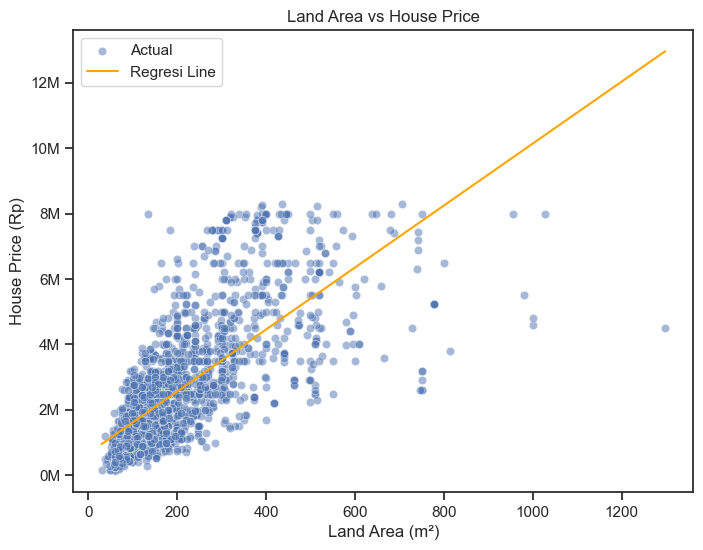

In [104]:
plt.figure(figsize=(8, 6))
ax = sns.scatterplot(x=df_no_outlier["luas_tanah_sqm"], y=df_no_outlier["harga_rp"], alpha=0.5, label="Actual")
ax = sns.lineplot(x=df_no_outlier["luas_tanah_sqm"], y=model.predict(X), color="orange", label="Regresi Line")
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{int(x/1e9)}M"))
plt.xlabel("Land Area (m²)")
plt.ylabel("House Price (Rp)")
plt.title("Land Area vs House Price")
plt.legend()
plt.show()

#### Insight
1. Luas tanah dan luas bangunan adalah faktor utama yang menentukan harga rumah.
1. Jarak ke pusat kota sedikit berpengaruh jika dilihat dari nilai korelasinya, tetapi tidak selalu menjadi faktor dominan.
2. Harga rumah di Bandung sangat bervariasi antar kecamatan, menunjukkan adanya segmentasi pasar yang beragam.


### Summary
1. Distribusi Iklan Rumah
    - Bandung Tengah menjadi pusat pasar properti, dengan jumlah rumah yang diiklankan paling banyak.
    - Bandung Barat memiliki jumlah iklan rumah paling sedikit, kemungkinan karena preferensi pasar yang berbeda atau banyak bagian Bandung Barat masuk kedalam wilayah Kabupaten Bandung Barat
2. Distribusi Harga Rumah di Setiap Wilayah
    - Bandung Utara memiliki median harga rumah tertinggi, menunjukkan dominasi hunian premium.
    - Bandung Timur menjadi kawasan dengan median harga rumah paling rendah, lebih cocok untuk pembeli dengan anggaran terbatas.
    - Tiga kecamatan dengan median harga tertinggi berada di Bandung Utara, yaitu Bandung Wetan, Cibeunying Kaler, dan Coblong.
3. Segmentasi Pasar Berdasarkan Harga
    - Bandung Utara menjadi wilayah hunian mewah, di mana 60% rumah yang diiklankan berada di kisaran harga Rp3–7 miliar dan di atas Rp7 miliar.
    - Bandung Timur mendominasi segmen rumah dengan harga Rp500 juta – Rp1,5 miliar, menjadi pilihan utama bagi pembeli kelas menengah.
    - Perbedaan harga terlihat dari ukuran rumah, di mana rumah dengan luas tanah 121–200 m² di Bandung Timur lebih murah 12% (sekitar Rp200 juta) dibandingkan rumah 61–120 m² di Bandung Utara. Ini menunjukkan bahwa Bandung Timur menawarkan ruang lebih luas dengan harga lebih terjangkau, sementara Bandung Utara memiliki harga tanah yang jauh lebih mahal.
4. Keunikan Kecamatan Cibeunying Kidul
    - Dari empat kecamatan di Bandung Utara, tiga di antaranya didominasi rumah mewah dengan harga miliaran rupiah.
    - Cibeunying Kidul justru berbeda, karena mayoritas rumahnya berada dalam kisaran Rp500 juta – Rp1,5 miliar.
    - Hal ini kemungkinan besar disebabkan oleh median luas tanah yang lebih kecil serta jarak yang sedikit lebih jauh ke pusat kota dibandingkan tiga kecamatan lain di Bandung Utara.
5. Kecamatan dengan Dominasi Rumah Standar
    - Antapani dan Arcamanik menjadi dua kecamatan utama yang menyumbang rumah dalam kisaran Rp500 juta – Rp1,5 miliar, memperkuat posisi Bandung Timur sebagai pusat hunian kelas menengah.
6. Faktor Penentu Harga Rumah
    - Luas tanah dan luas bangunan menjadi faktor utama yang mempengaruhi harga rumah, dengan korelasi yang cukup tinggi.
    - Jarak ke pusat kota memang memiliki pengaruh terhadap harga rumah, tetapi tidak terlalu signifikan dibandingkan luas tanah dan bangunan. Ini menunjukkan bahwa ukuran rumah tetap menjadi pertimbangan utama bagi pembeli di Bandung.

In [105]:
df_clean.groupby('wilayah')['harga_rp'].median()

wilayah
Bandung Barat     3000000000
Bandung Selatan   1850000000
Bandung Tengah    2500000000
Bandung Timur     1250000000
Bandung Utara     3600000000
Name: harga_rp, dtype: float64